# Телекоммуникации

## Подготовка данных

Откроем файлы с данными и изучим их, для этого подключим библиотеку `pandas` помимо неё подключим еще остальные библиотеки, которые нам пригодятся. Для того чтобы прочитать данные из датасета воспользуемся методом `read_csv`, для получения общей информации о датасете воспользуемся методом `info`. Но для начала установим недостающие библиотеки.

In [1]:
!pip install phik

In [2]:
!pip install catboost

In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np
import phik
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.dummy import DummyClassifier
import catboost
from matplotlib import pyplot as plt

# настройки
warnings.filterwarnings("ignore")

In [4]:
# константы
RANDOM_STATE = 100723

In [5]:
try:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    data_contract = pd.read_csv('contract_new.csv')
    data_internet = pd.read_csv('internet_new.csv')
    data_personal = pd.read_csv('personal_new.csv')
    data_phone = pd.read_csv('phone_new.csv')

In [6]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [11]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Все датасеты с разным количеством строк. Первый и третий датасет имеет одинаковое количество строк и они содержат больше всего строк. В первом датасете содержится информацию о договорах клиента:

- `customerID` — индентификатор клиента;
- `BeginDate` — дата заключения договора;
- `EndDate` — дата окончания договора;
- `Type` — тип оплаты по договору;
- `PaperlessBilling` — пользуется ли клиент электронными чеками;
- `PaymentMethod` — способ оплаты;
- `MonthlyCharges` — ежемесячные платеж;
- `TotalCharges` — сколько всего заплатил клиент по договору.

Стоит отметить, что в последнем столбце указан строковый тип данных `TotalCharges`, хотя там подходтит числовой.

В третьем датасете содержатся следующие персональные данные клиента:

- `customerID` — индентификатор клиента;
- `gender` — пол клиента;
- `SeniorCitizen` — клиент пенсионного возраста;
- `Partner` — наличие у клиента партнера;
- `Dependents` — наличие у клиента инждевенцев.

Здесь стоит отметить, что в столбце `SeniorCitizen` указан числовый тип данных в том время как в двух следующих столбцах `Partner` и `Dependents` указан строковый тип данных.

Во втором и четвертом датасете количество строк отличается от количество строк в первом и третьем датасете, а также между собой. Во втором датасете содержится информация о подключенных услугах клиента связанных с интернетом:

- `customerID` — индентификатор клиента;
- `InternetService` — тип подключения интернета;
- `OnlineSecurity` — подключена услуга блокировки небезопасных сайтов;
- `OnlineBackup` — есть облачное хранилища файлов для резервного копирования данных;
- `DeviceProtection` — подключен антивирус;
- `TechSupport` — оформлена выделенная линия технической поддержки;
- `StreamingTV` — подключено стриминговое телевидение;
- `StreamingMovies` — подключен каталог фильмов.

Во втором датасете меньшего всего строк, это связано с тем, что не все клиенты подключают себе дополнительные услуги.

В четвертом датасете меньше всего столбцов, он содержит следующую информацию:

- `customerID` — индентификатор клиента;
- `MultipleLines` — подключено несколько каналов интернета.

Как можно заметить, количество строк в данном датасете меньше, чем в первом и в третьем, что говорит о том, что не все клиенты подключают себе несколько каналов интернета.

Во всех предоставленных датасетах наименование столбцов указаны не по стандарту Python, напишем небольшую функцию, с помощью которой переименуем наши столбцы:

In [14]:
def rename_columns(columns): #функция для переименования столбцов
    '''
    Функция приводит название столбцов в датасете в формат shake case по стандарту Python,
    на вход функция принимает текущие названия столбцов в датасете в виде списка
    '''
    columns_rename = []
    new_name_column = ""
    for column in columns:
        for index_symbol in range(0, len(column), 1):
            if index_symbol == 0 and column[index_symbol].istitle(): #метод istitle проверяет является ли символ заглавным
                new_name_column += column[index_symbol].lower()
            elif index_symbol > 0 and column[index_symbol].istitle() and index_symbol != len(column) - 1:
                new_name_column += '_' + column[index_symbol].lower()
            elif column[index_symbol].istitle() and index_symbol == len(column) - 1:
                new_name_column += column[index_symbol].lower()
            else:
                new_name_column += column[index_symbol]
        columns_rename.append(new_name_column)
        new_name_column = ""
    return columns_rename

Функцию написали, применим её теперь на наших датасетах:

In [15]:
data_contract.columns = rename_columns(data_contract.columns)
data_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [16]:
data_internet.columns = rename_columns(data_internet.columns)
data_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [17]:
data_personal.columns = rename_columns(data_personal.columns)
data_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [18]:
data_phone.columns = rename_columns(data_phone.columns)
data_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

Столбцы во всех датасетах успешно переименовались. **Далее в проекте будем использовать наименования столбцов в датасетах, которые получили с помощью функции**.

Как мы заметили ранее, не во всех столбцах в датасете указан корректный тип данных, например в столбце `total_charges` в датасете по договарам клиентов, изменим тип данных в этом столбце с текстового на числовой:

In [19]:
data_contract['total_charges'] = pd.to_numeric(data_contract['total_charges'], errors='coerce')
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Посчитаем количество процущенных строк в датасетах:

In [20]:
data_contract.isna().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64

In [21]:
data_internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [22]:
data_personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [23]:
data_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

Пропущенные значения есть в одном `total_charges` в датасете по договорам, посмотрим данные, где указаны пропущенные значения:

In [24]:
data_contract[data_contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Пропущенные значения в столбце `total_charges` указаны только у тех клиентов, которых заключили договор 1 февраля 2020 года, этой датой у нас заканчиваются предоставленные данные согласно описанию проекта. Природа наличия пропусков здесь следующая, так как данные заканчиваются датой 1 февраля 2020, клиент просто не успел еще даже за месяц заплатить, соотвественно мы не знаем сколько всего денег он потратил на услуги. Пропусков у нас совсем мало, можем удалить данные по этим клиентам во всех датасетах:

In [25]:
print('Количество строк в датасете data_phone до удаления', len(data_phone))
data_phone = data_phone[data_phone['customer_id'].isin(data_contract[~(data_contract['total_charges'].isna())]['customer_id'])]
print('Количество строк в датасете data_phone после удаления', len(data_phone))

Количество строк в датасете data_phone до удаления 6361
Количество строк в датасете data_phone после удаления 6352


In [26]:
print('Количество строк в датасете data_personal до удаления', len(data_personal))
data_personal = data_personal[data_personal['customer_id'].isin(data_contract[~(data_contract['total_charges'].isna())]['customer_id'])]
print('Количество строк в датасете data_personal после удаления', len(data_personal))

Количество строк в датасете data_personal до удаления 7043
Количество строк в датасете data_personal после удаления 7032


In [27]:
print('Количество строк в датасете data_internet до удаления', len(data_internet))
data_internet = data_internet[data_internet['customer_id'].isin(data_contract[~(data_contract['total_charges'].isna())]['customer_id'])]
print('Количество строк в датасете data_internet после удаления', len(data_internet))

Количество строк в датасете data_internet до удаления 5517
Количество строк в датасете data_internet после удаления 5512


In [28]:
print('Количество строк в датасете data_contract до удаления', len(data_contract))
data_contract = data_contract[data_contract['customer_id'].isin(data_contract[~(data_contract['total_charges'].isna())]['customer_id'])]
print('Количество строк в датасете data_contract после удаления', len(data_contract))

Количество строк в датасете data_contract до удаления 7043
Количество строк в датасете data_contract после удаления 7032


Данные с пропусками успешно удались, не во всех датасетах удалилось 11 записей, это связано с тем, что клиенты, которые заключили договор 1 февраля 2020 года, не все оформляли себе дополнительные услуги.

Проверим теперь количество дубликатов во всех датасетах:

In [29]:
data_contract.duplicated().sum()

0

In [30]:
data_internet.duplicated().sum()

0

In [31]:
data_personal.duplicated().sum()

0

In [32]:
data_phone.duplicated().sum()

0

Явных дубликатов у нас нет, переведем теперь все строковые значения, которые у нас есть в датасетах, в нижний регистр, и посчитаем количество дубликатов ещё раз, так мы сможем найти неявные дубликаты, потому переведем все строковые значения в один регистр и например значение типа кабеля `DSL` и `dsl` станет одним значением `dsl`. Так как у нас несколько датасетов, напишем функцию, которая будет нам значения в столбцах в нижний регистр:

In [33]:
def data_to_lower(data):
    '''
    Функция переводит значения в столбцах в нижний регистр
    '''
    for column in data.columns:
        if data[column].dtype == 'O':
            data[column] = data[column].str.lower()
            
    return data

In [34]:
data_contract = data_to_lower(data_contract)
data_contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.60
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.50
...,...,...,...,...,...,...,...,...
7038,6840-resvb,2018-02-01,no,one year,yes,mailed check,84.80,2035.20
7039,2234-xaduh,2014-02-01,no,one year,yes,credit card (automatic),103.20,7430.40
7040,4801-jzazl,2019-03-01,no,month-to-month,yes,electronic check,29.60,325.60
7041,8361-ltmkd,2019-07-01,no,month-to-month,yes,mailed check,74.40,520.80


In [35]:
data_internet = data_to_lower(data_internet)
data_internet

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-vhveg,dsl,no,yes,no,no,no,no
1,5575-gnvde,dsl,yes,no,yes,no,no,no
2,3668-qpybk,dsl,yes,yes,no,no,no,no
3,7795-cfocw,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,fiber optic,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...
5512,6840-resvb,dsl,yes,no,yes,yes,yes,yes
5513,2234-xaduh,fiber optic,no,yes,yes,no,yes,yes
5514,4801-jzazl,dsl,yes,no,no,no,no,no
5515,8361-ltmkd,fiber optic,no,no,no,no,no,no


In [36]:
data_personal = data_to_lower(data_personal)
data_personal

,customer_id,gender,senior_citizen,partner,dependents
0,7590-vhveg,female,0,yes,no
1,5575-gnvde,male,0,no,no
2,3668-qpybk,male,0,no,no
3,7795-cfocw,male,0,no,no
4,9237-hqitu,female,0,no,no
...,...,...,...,...,...
7038,6840-resvb,male,0,yes,yes
7039,2234-xaduh,female,0,yes,yes
7040,4801-jzazl,female,0,yes,yes
7041,8361-ltmkd,male,1,yes,no


In [37]:
data_phone = data_to_lower(data_phone)
data_phone

,customer_id,multiple_lines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes
...,...,...
6356,2569-wgero,no
6357,6840-resvb,yes
6358,2234-xaduh,yes
6359,8361-ltmkd,yes


Данные успешно перевели в нижний регистр, пересчитаем дубликаты ещё раз, чтобы найти неявные дубликаты:

In [38]:
data_contract.duplicated().sum()

0

In [39]:
data_internet.duplicated().sum()

0

In [40]:
data_personal.duplicated().sum()

0

In [41]:
data_phone.duplicated().sum()

0

Неявных дубликатов в датасетах тоже нет.

В датасете по договорам клиентов, есть столбец `end_date` - дата прекращения договора, посмотрим сколько клиентов уже перестали пользоваться услугами, для этого добавим новый столбец `exited` - факт ухода клиента, который заполнил следующим образом - если, у клиента указана дата прекращения договора, то указываем в этом столбце значение **1**, иначе указываем значение **0**:

In [42]:
data_contract['exited'] = np.where(data_contract['end_date'] == 'no', 0, 1)
data_contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited
0,7590-vhveg,2020-01-01,no,month-to-month,yes,electronic check,29.85,31.04,0
1,5575-gnvde,2017-04-01,no,one year,no,mailed check,56.95,2071.84,0
2,3668-qpybk,2019-10-01,no,month-to-month,yes,mailed check,53.85,226.17,0
3,7795-cfocw,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1960.60,0
4,9237-hqitu,2019-09-01,no,month-to-month,yes,electronic check,70.70,353.50,0
...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,2018-02-01,no,one year,yes,mailed check,84.80,2035.20,0
7039,2234-xaduh,2014-02-01,no,one year,yes,credit card (automatic),103.20,7430.40,0
7040,4801-jzazl,2019-03-01,no,month-to-month,yes,electronic check,29.60,325.60,0
7041,8361-ltmkd,2019-07-01,no,month-to-month,yes,mailed check,74.40,520.80,0


Данные в новом столбце успешно заполнились, два новых столбца, в одном укажем год заключения договора, в другом год прекращения договора, но для начала преобразуем столбцы с датами в корректный тип данных:

In [43]:
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'], format='%Y-%m-%d')
data_contract['end_date'] = pd.to_datetime(data_contract['end_date'], format='%Y-%m-%d', errors='coerce')
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   exited             7032 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 521.9+ KB


Тип данных успешно изменился, добавим столбцами с годами:

In [44]:
data_contract['begin_date_year'] = data_contract['begin_date'].dt.year
data_contract['end_date_year'] = data_contract['end_date'].dt.year
data_contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,end_date_year
0,7590-vhveg,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,0,2020,NaN
1,5575-gnvde,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,0,2017,NaN
2,3668-qpybk,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,0,2019,NaN
3,7795-cfocw,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,0,2016,NaN
4,9237-hqitu,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,0,2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-resvb,2018-02-01,NaT,one year,yes,mailed check,84.80,2035.20,0,2018,NaN
7039,2234-xaduh,2014-02-01,NaT,one year,yes,credit card (automatic),103.20,7430.40,0,2014,NaN
7040,4801-jzazl,2019-03-01,NaT,month-to-month,yes,electronic check,29.60,325.60,0,2019,NaN
7041,8361-ltmkd,2019-07-01,NaT,month-to-month,yes,mailed check,74.40,520.80,0,2019,NaN


Столбцы с годами успешно добавились, посмотрим теперь в разрезре по годам, сколько клиентов заключили договор, а сколько расторгли:

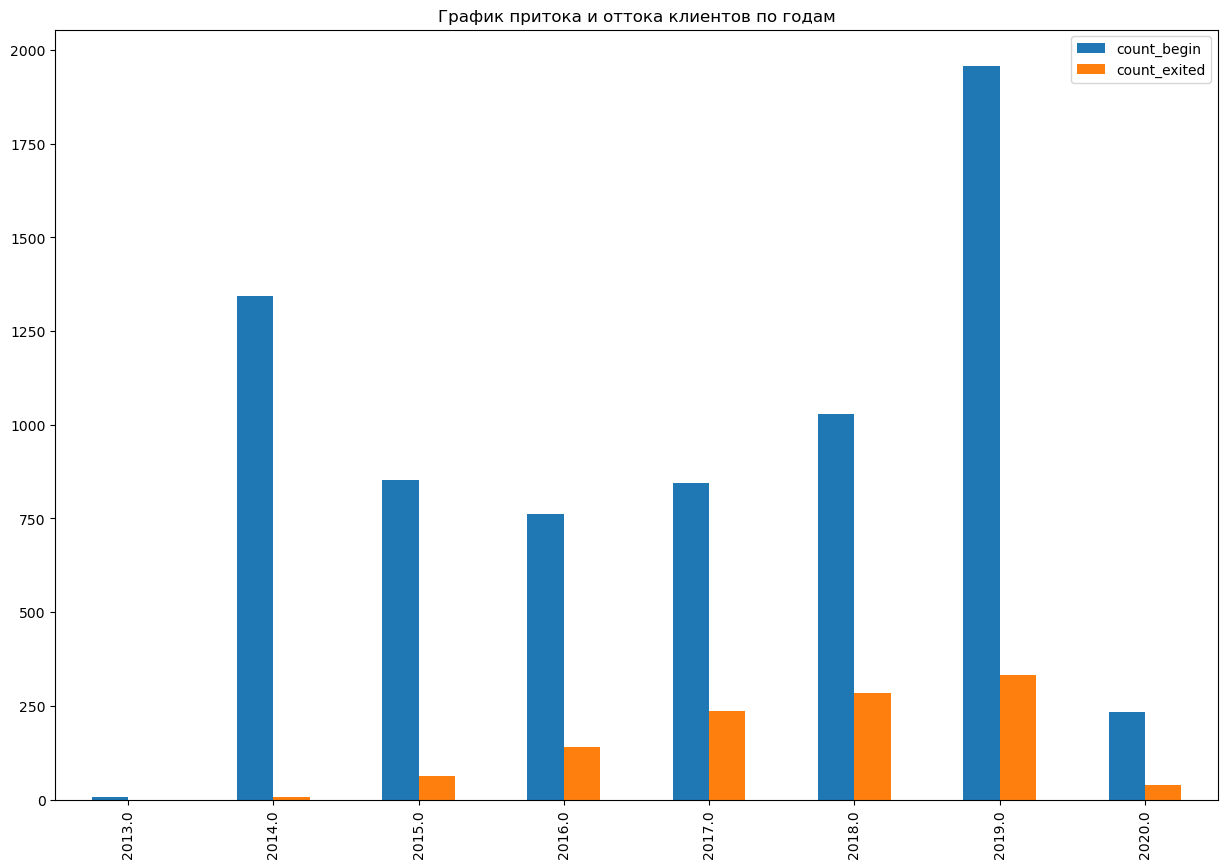

In [45]:
#используем sum, чтобы посчитать количество расторженных договоров, если использовать count, то будут учитываться 
#клиенты, которые ещё пользуются услугами, т.к столбец exited содержит значения 0 и 1
data_contract_end_year = data_contract.pivot_table(index=['end_date_year'], values='exited', aggfunc=['sum'])
data_contract_end_year.columns = ['count_exited']

data_contract_begin_year = data_contract.pivot_table(index=['begin_date_year'], values='exited', aggfunc=['count'])
data_contract_begin_year.columns = ['count_begin']

data_contract_begin_end_year = pd.concat([data_contract_begin_year, data_contract_end_year], axis=1)
data_contract_begin_end_year.plot(y=['count_begin', 'count_exited'], kind='bar', figsize=(15, 10),
                                  title='График притока и оттока клиентов по годам')
pass

По графику видно, что больше всего договор заключили в **2019** году, однако в этом году также ушло больше всех клиентов, чем в остальные года. Если смотреть соотношение сколько клиентов пришло и сколько ушло, то самым успешным будет **2014** год, в этом году заключили больше всего договоров, если не брать в расчет **2019** году, а также в этом году самый минимальный процент расторжения договор. **2013** и **2020** года не рассматриваем, по графику там самые не высокие столбцы, что говорит о том, что за эти года данные не полные.

Посмотрим теперь как распределяется выручка по годам. Сформируем срез по выручке по годам, **2013** и **2020** год из среза уберем, так как данные за эти года не полные:

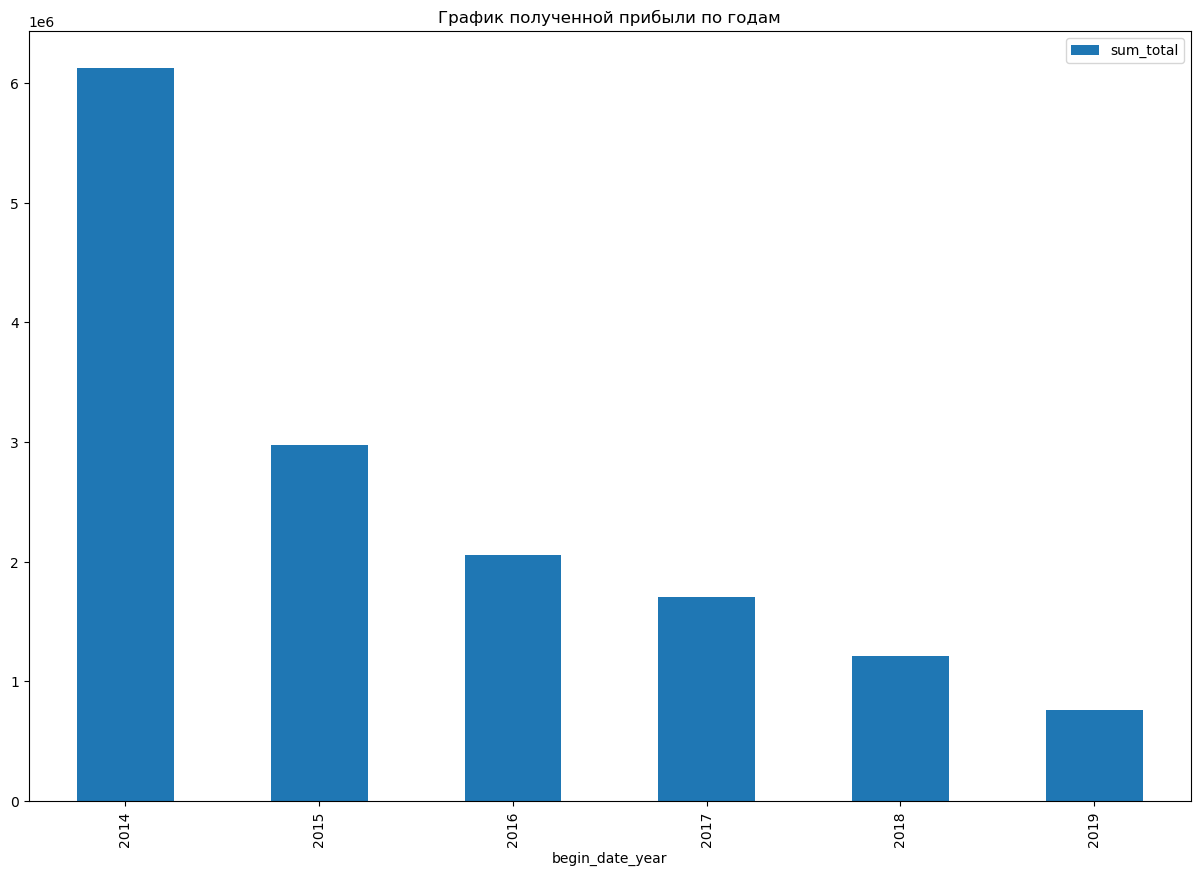

In [46]:
data_contract_total = data_contract[(data_contract['begin_date_year'] > 2013) & (data_contract['begin_date_year'] < 2020)
                                   ].pivot_table(index='begin_date_year', values='total_charges', aggfunc=['sum'])
data_contract_total.columns = ['sum_total']
data_contract_total.plot(y=['sum_total'], kind='bar', figsize=(15, 10), title='График полученной прибыли по годам')
pass

Согласно графику самая высокая выручка у компании была в **2014** году, затем в **2015** году выручка падает можно сказать, что в **2** раза и с каждым выручка становилась все меньше. Стоит отметить, что в **2019** у компании был самый большой прирост по клиентам по сравнению с другими годами, однако самая низкая выручка.

Посмотрим теперь сколько клиентов ушло взависимости от способа оплаты:

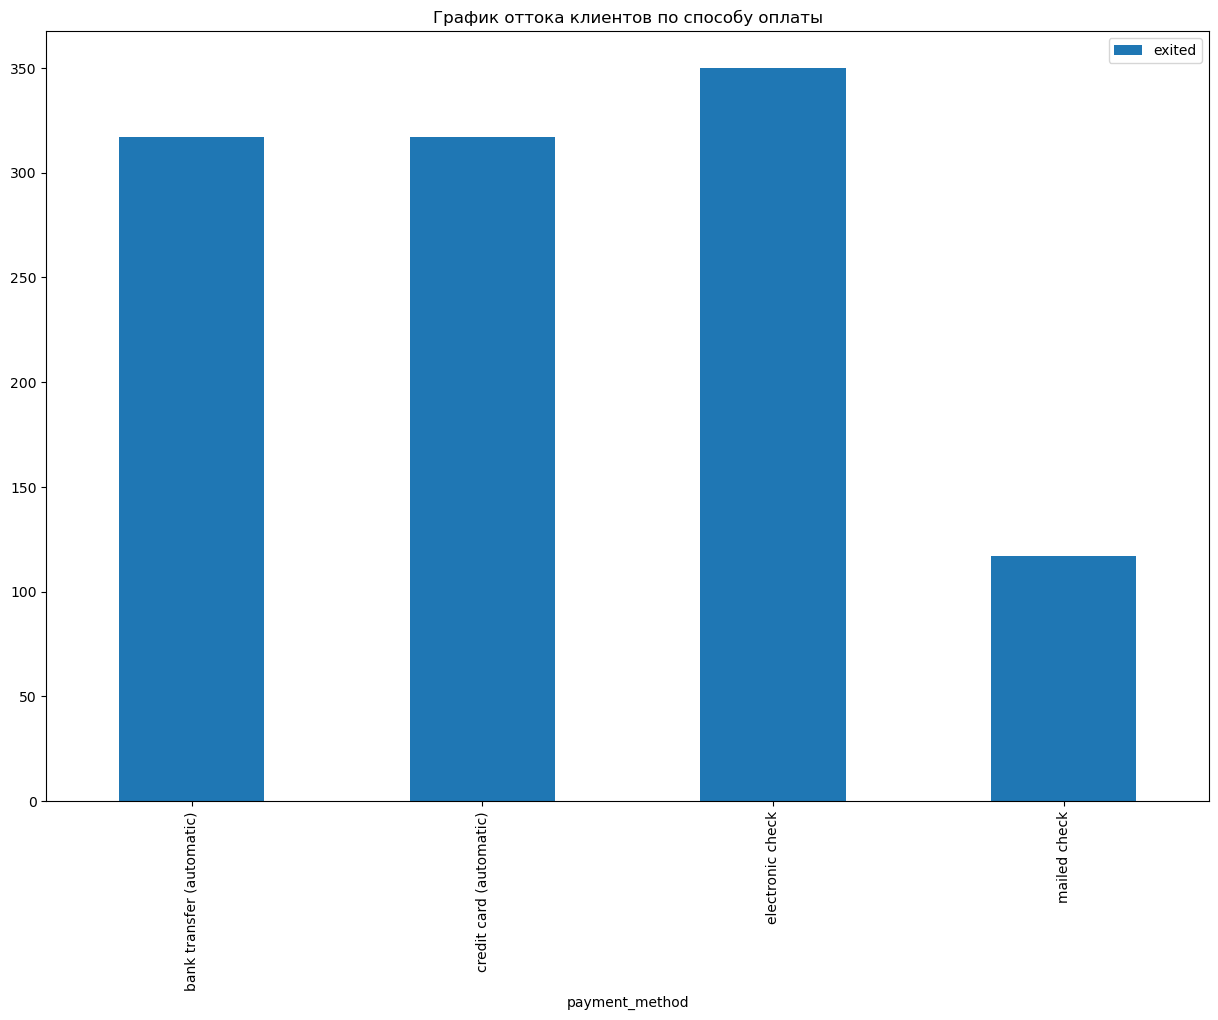

In [47]:
data_contract_payment = data_contract.pivot_table(index='payment_method', values='exited', aggfunc='sum')
data_contract_payment.plot(kind='bar', figsize=(15, 10), title='График оттока клиентов по способу оплаты')
pass

Мешьне всего ушло клиентов тех, кто использует бумажные чеки, почти что половину меньше, чем любой другой из трех вариантов будь то банковский перевод, электронный чек или кредитная карта.

Посмотрим сколько клиентов ушло в зависимости от типа оплаты по договору:

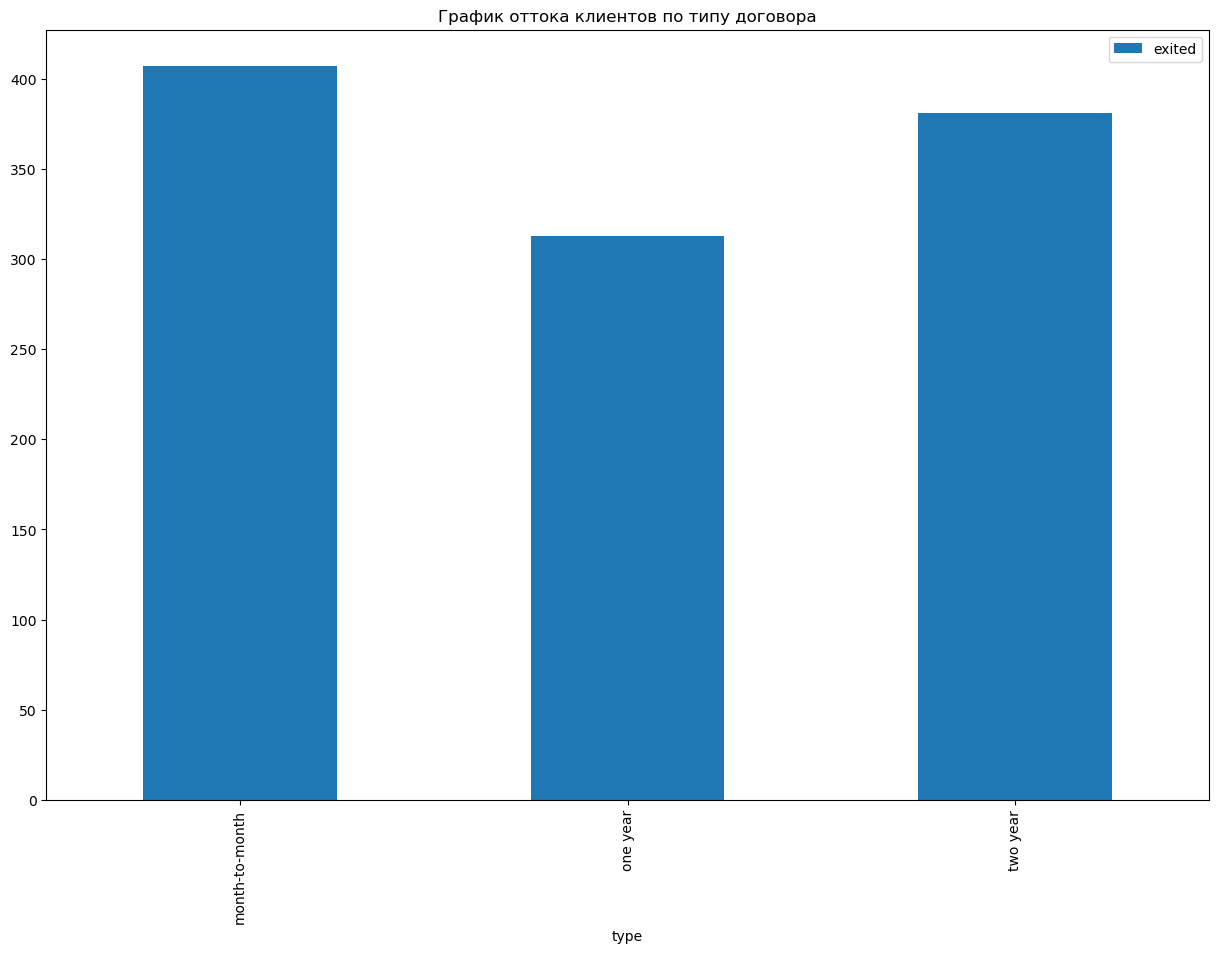

In [48]:
data_contract_type = data_contract.pivot_table(index='type', values='exited', aggfunc='sum')
data_contract_type.plot(kind='bar', figsize=(15, 10), title='График оттока клиентов по типу договора')
pass

По типу договора не такая заметная разница по сравнению со способом оплаты, чуть меньше ушло клиентов, который платят по договору в раз в год по сравнению с теми клиентами, которые платят каждый месяц и раз в два года.

Объединим теперь все наши датасеты в один по индефикатору клиента, чтобы мы могли проанализировать сколько клиентов ушло в зависимости от количества подключенных услуг, пола, возраста и наличия партнера или иждевенца:

In [49]:
data = data_contract.merge(data_internet, on='customer_id', how='outer').merge(
    data_personal, on='customer_id', how='outer').merge(data_phone, on='customer_id', how='outer')
data

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-vhveg,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,0,2020,...,yes,no,no,no,no,female,0,yes,no,NaN
1,5575-gnvde,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,0,2017,...,no,yes,no,no,no,male,0,no,no,no
2,3668-qpybk,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,0,2019,...,yes,no,no,no,no,male,0,no,no,no
3,7795-cfocw,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,0,2016,...,no,yes,yes,no,no,male,0,no,no,NaN
4,9237-hqitu,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,0,2019,...,no,no,no,no,no,female,0,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-resvb,2018-02-01,NaT,one year,yes,mailed check,84.80,2035.20,0,2018,...,no,yes,yes,yes,yes,male,0,yes,yes,yes
7028,2234-xaduh,2014-02-01,NaT,one year,yes,credit card (automatic),103.20,7430.40,0,2014,...,yes,yes,no,yes,yes,female,0,yes,yes,yes
7029,4801-jzazl,2019-03-01,NaT,month-to-month,yes,electronic check,29.60,325.60,0,2019,...,no,no,no,no,no,female,0,yes,yes,NaN
7030,8361-ltmkd,2019-07-01,NaT,month-to-month,yes,mailed check,74.40,520.80,0,2019,...,no,no,no,no,no,male,1,yes,no,yes


Данные из всех датасетов успешно объединились.

## Исследовательский анализ

Проверим количество столбцов в объединном датафрейме:

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   exited             7032 non-null   int32         
 9   begin_date_year    7032 non-null   int64         
 10  end_date_year      1101 non-null   float64       
 11  internet_service   5512 non-null   object        
 12  online_security    5512 non-null   object        
 13  online_backup      5512 non-null   object        
 14  device_p

Из-за того что объединили все датафреймы в один снова появились столбцы с пустыми значениями, они появились у тех столбцов, куда добавились новые индефикаторы клиента, например столбцы в которых содержатся информация о подключение дополнительных услуг и дополнительной линии. Чтобы не было пустых значений, заполним данные в этих столбцах значением **no**, так как изначально в эти столбцы добавлялась информация только о тех клиентах, которые подключали себе дополнительные опции, соответственно, если в данном столбце указан пропуск, то клиент не подключал себе данную услугу:

In [51]:
data['internet_service'] = data['internet_service'].fillna('no')
data['online_security'] = data['online_security'].fillna('no')
data['online_backup'] = data['online_backup'].fillna('no')
data['device_protection'] = data['device_protection'].fillna('no')
data['tech_support'] = data['tech_support'].fillna('no')
data['streaming_tv'] = data['streaming_tv'].fillna('no')
data['streaming_movies'] = data['streaming_movies'].fillna('no')
data['multiple_lines'] = data['multiple_lines'].fillna('no')

In [52]:
data.isna().sum()

customer_id             0
begin_date              0
end_date             5931
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
exited                  0
begin_date_year         0
end_date_year        5931
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
dtype: int64

Пропуски успешно заполнились. В столбцах `end_date` и `end_date_year` пропуски заполнять не будем, так как данные пропуски были созданы искусственно, когда строковый тип данных преобразовали в дату.

Как видно данные из всех столбцов успешно подтянулись, можем теперь детальнее проанализировтаь данные и для начала добавим новый столбец `added_services` в который будет записывать два значения, **0** - клиент не пользуются дополнительные услугами, **1** - клиент пользуется дополнительными услугами:

In [53]:
data['added_services'] = np.where(((data['internet_service'] == 'yes') | (data['online_security'] == 'yes') | (
                                    data['online_backup'] == 'yes') | (data['device_protection'] == 'yes') | (
                                    data['tech_support'] == 'yes') | (data['streaming_tv'] == 'yes') | (
                                    data['streaming_movies'] == 'yes')), 1, 0)
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,added_services
0,7590-vhveg,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,0,2020,...,no,no,no,no,female,0,yes,no,no,1
1,5575-gnvde,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,0,2017,...,yes,no,no,no,male,0,no,no,no,1
2,3668-qpybk,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,0,2019,...,no,no,no,no,male,0,no,no,no,1
3,7795-cfocw,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,0,2016,...,yes,yes,no,no,male,0,no,no,no,1
4,9237-hqitu,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,0,2019,...,no,no,no,no,female,0,no,no,no,0


Столбец успешно добавился, посмотрим теперь сколько клиентов пользуются дополнительные услугами с помощью графика:

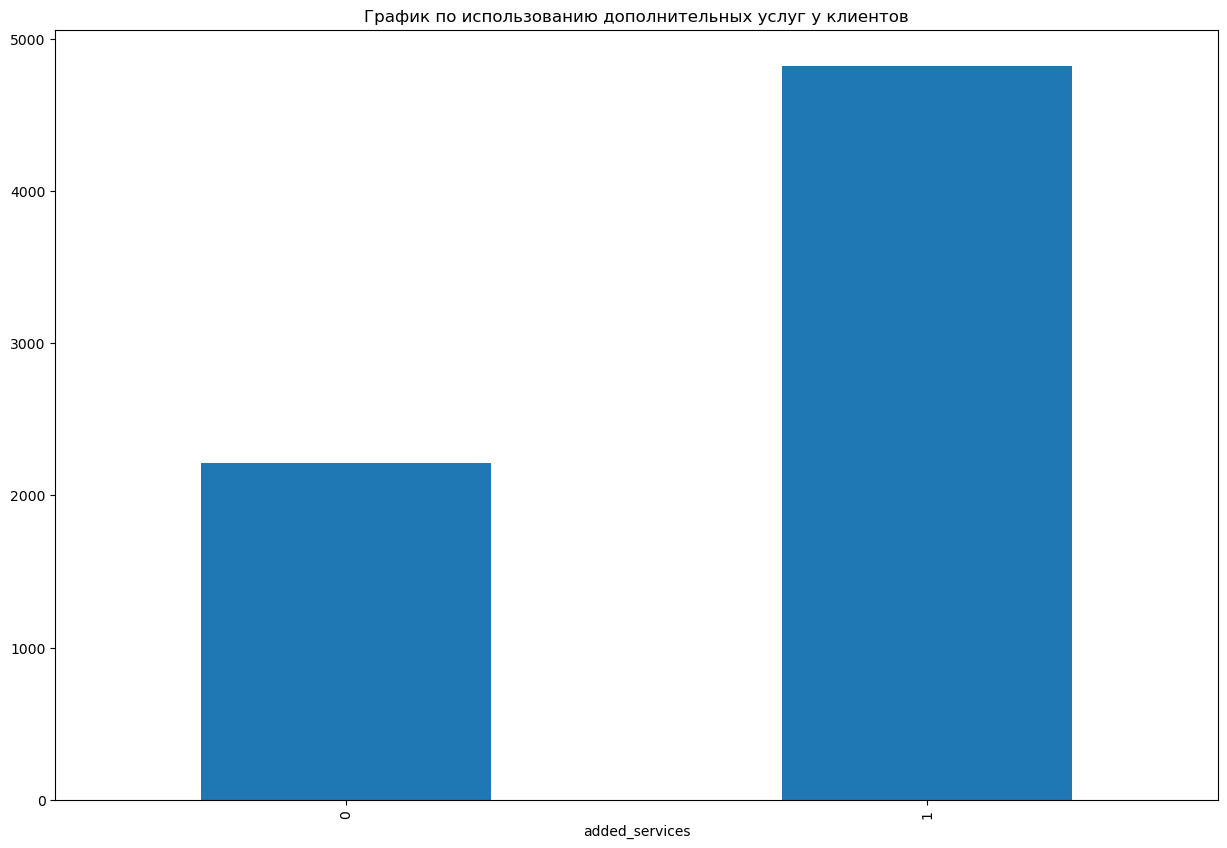

In [54]:
data.pivot_table(index='added_services', aggfunc='count')['customer_id'].plot(
    kind='bar', figsize=(15, 10), title='График по использованию дополнительных услуг у клиентов')
pass

По графику видно, что большая часть клиентов пользуется дополнительными услугами, около **30%** клиентов не подключали себе дополнительные услуги. Посмотрим теперь сколько ушло клиентов, которые подключали себе дополнительные услуги:

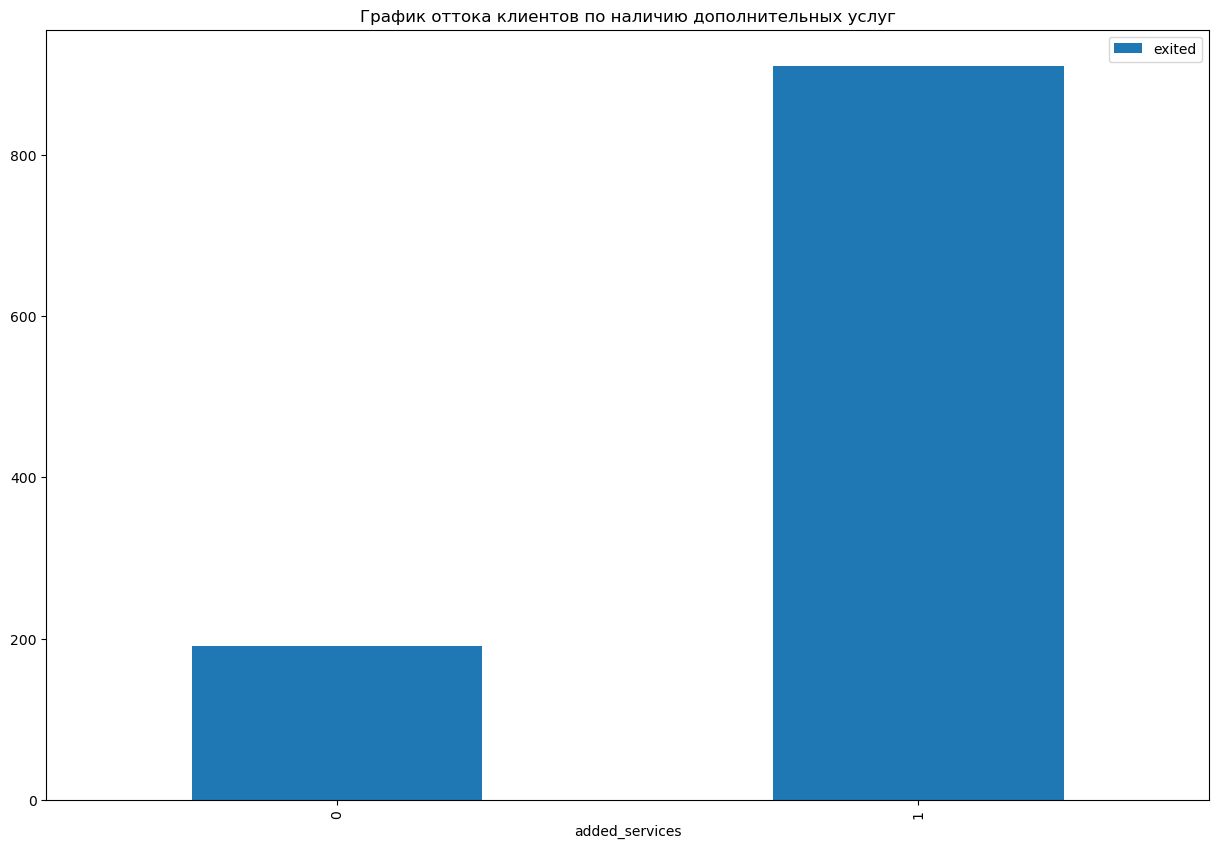

In [55]:
data.pivot_table(index='added_services', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по наличию дополнительных услуг')
pass

Граафик показывает, что большая часть клиентов, которая расторгла договор с компанией, пользовалась дополнительными услугами, что говорит о том, что клиент, который подключил себе дополнительные услуги, с большей вероятностью перестанет пользоваться услугами компании, чем клиент, который данные услуги не подключал.

Построим график зависимости ухода клиента взависимости от пола, чтобы определить, кто чаще прекращает пользоваться услугами компании, мужчины или женщины:

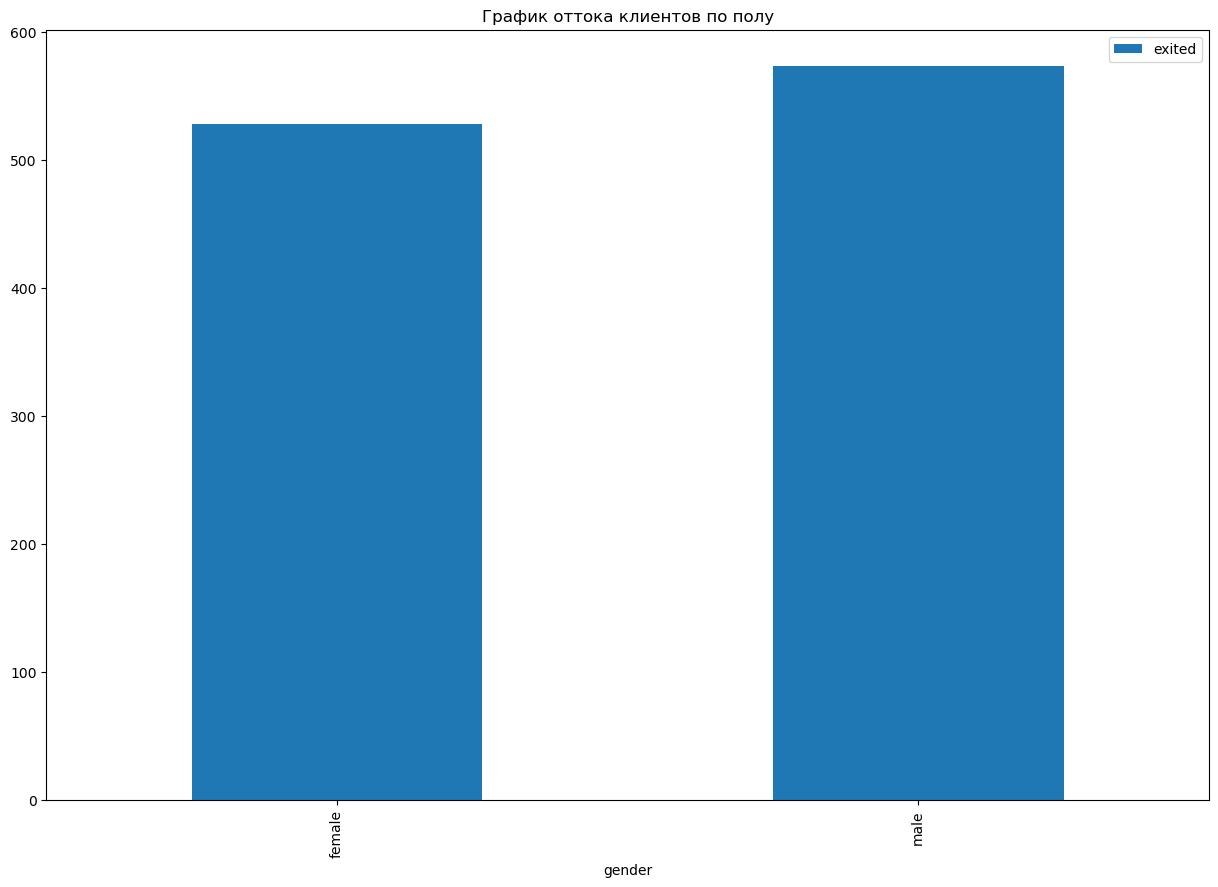

In [56]:
data.pivot_table(index='gender', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по полу')
pass

Как видно на графике мужчины чаще расторгают договор с компанией, чем женщины, однако разница не слишком большая, что говорит о том, что пол не влияет на прекращения использования услуг компании.

Построим теперь график, чтобы проверить как влияет возраст на то, что клиент уйдет:

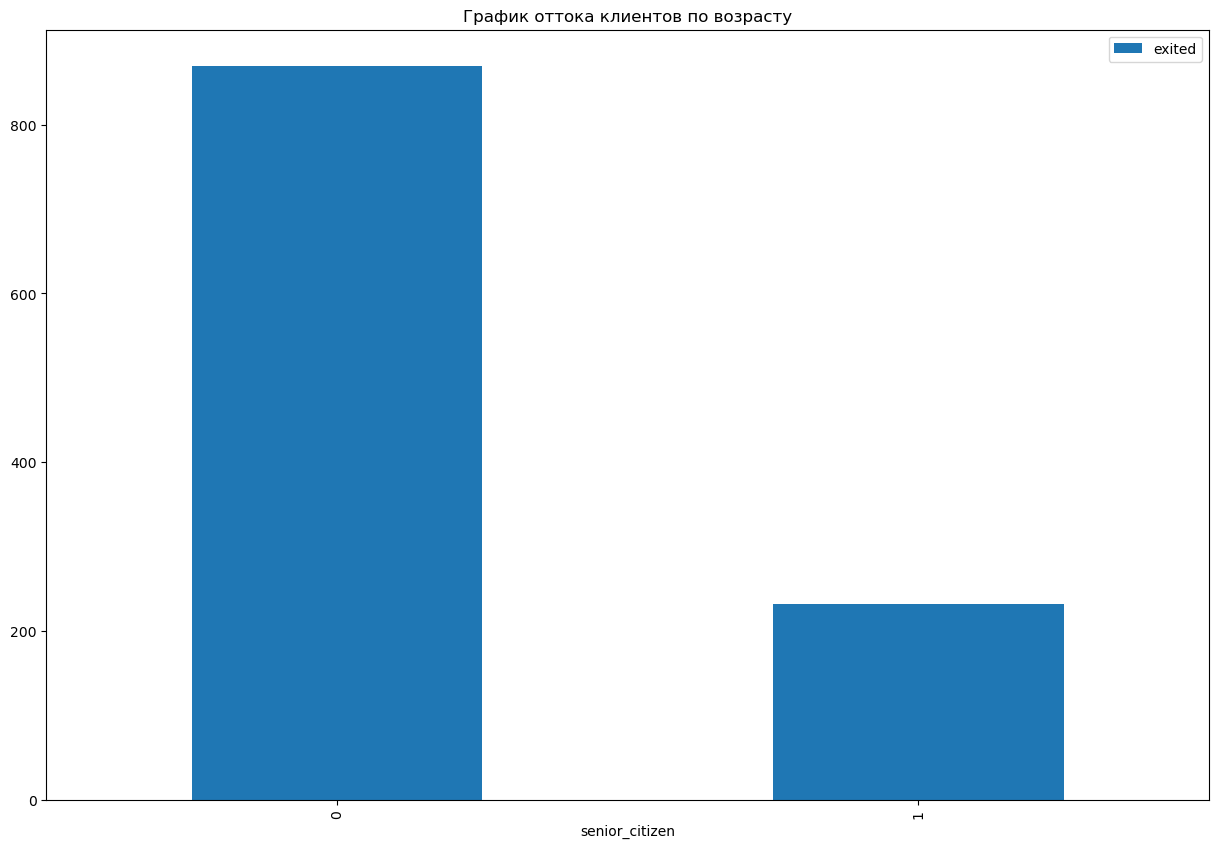

In [57]:
data.pivot_table(index='senior_citizen', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по возрасту')
pass

Как видно по графику, люди, которые не являются пенсионерами, чаще прекращают пользоваться услугами компании, чем сами пенсионеры, что говорит о том, что чем человек моложе, чем больше вероятность, что он откажется от услуг компании.

Посмотрим теперь как на уход клиента влияет наличие партнера:

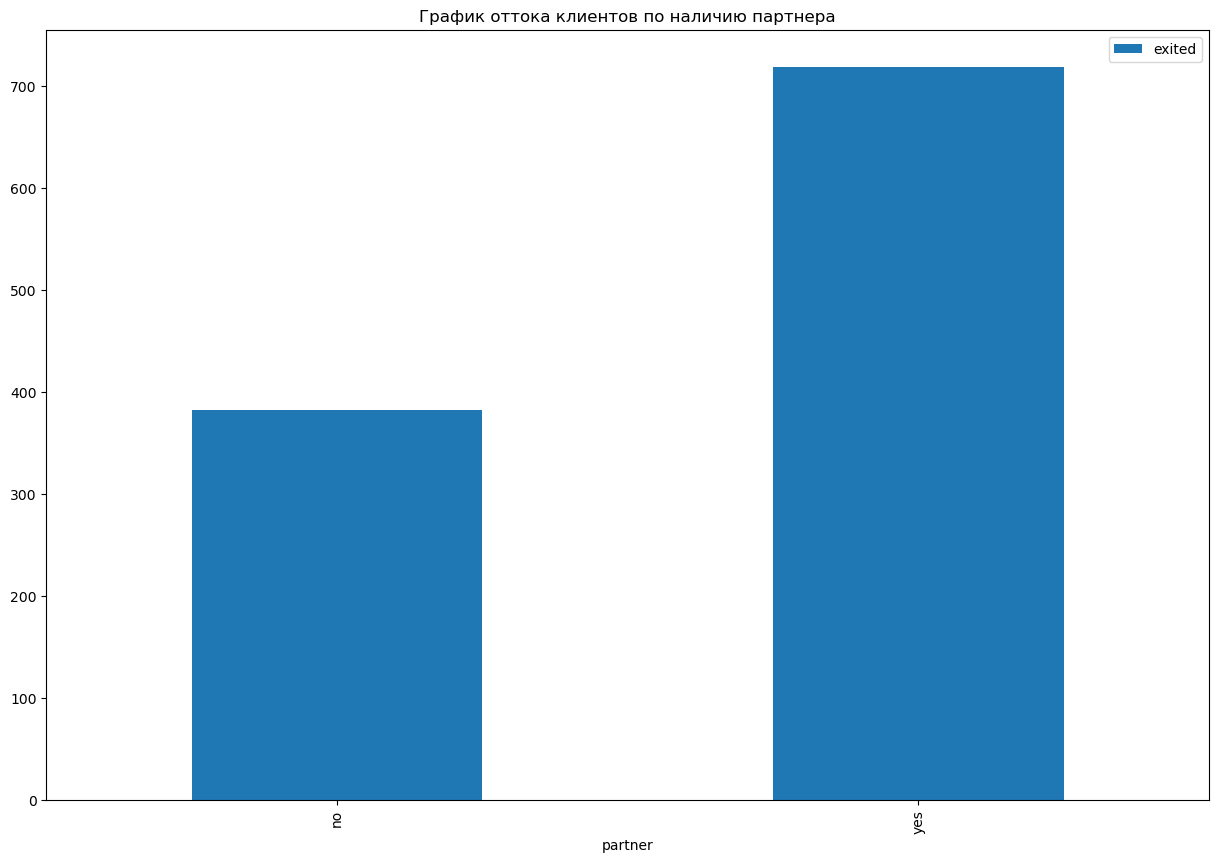

In [58]:
data.pivot_table(index='partner', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по наличию партнера')
pass

Согласно графику, клиенты, которые имеют партнеров, почти в **2** раза чаще отказываются от услуг компании, чем одинокие клиенты. Посмотрим теперь как на уход клиента, влияет наличие иждевенцев:

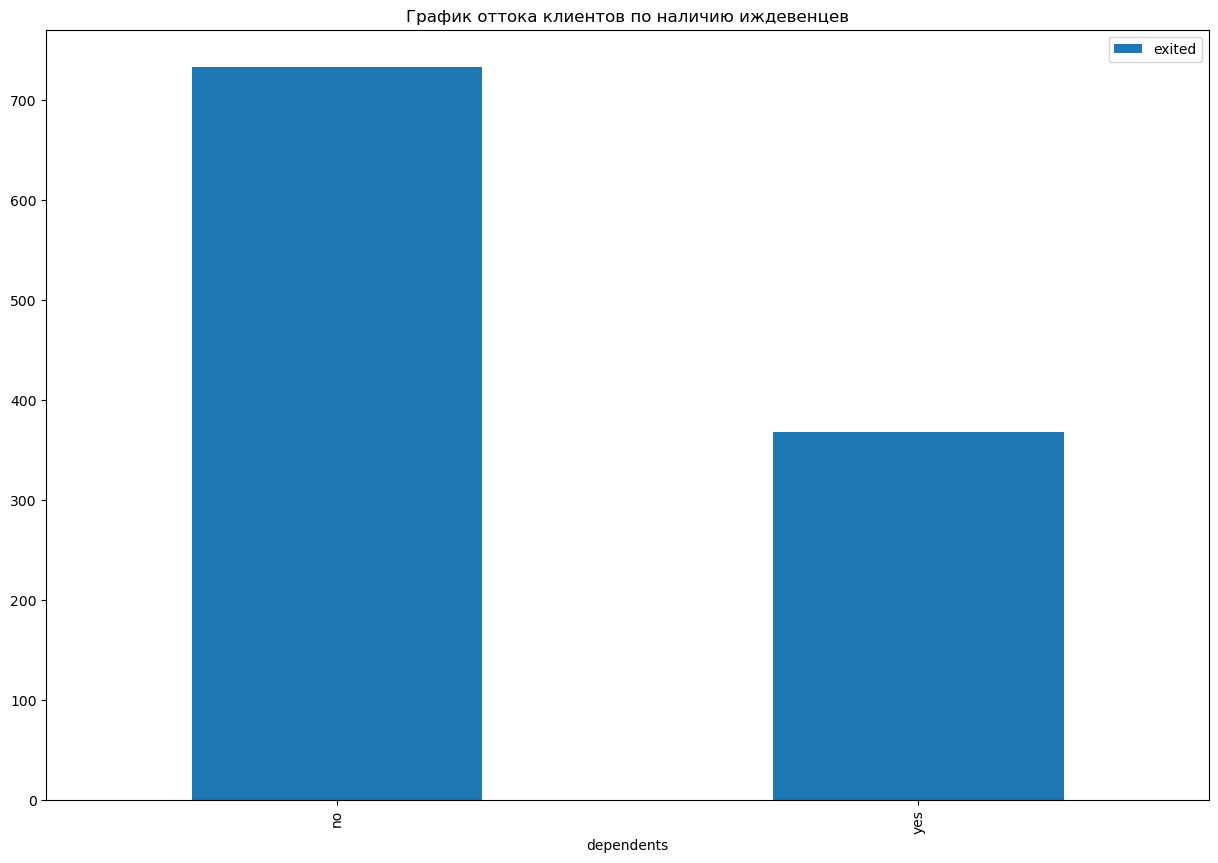

In [59]:
data.pivot_table(index='dependents', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по наличию иждевенцев')
pass

Случай с наличием иждевенцов прямо противоположный случаю с партнерами, клиенты, у которых есть иждевенцы почти в **2** раза реже прекращают пользоваться услугами компании. Посмотрим теперь сколько клиентов с дополнительынми линиями отказались от услуг компании:

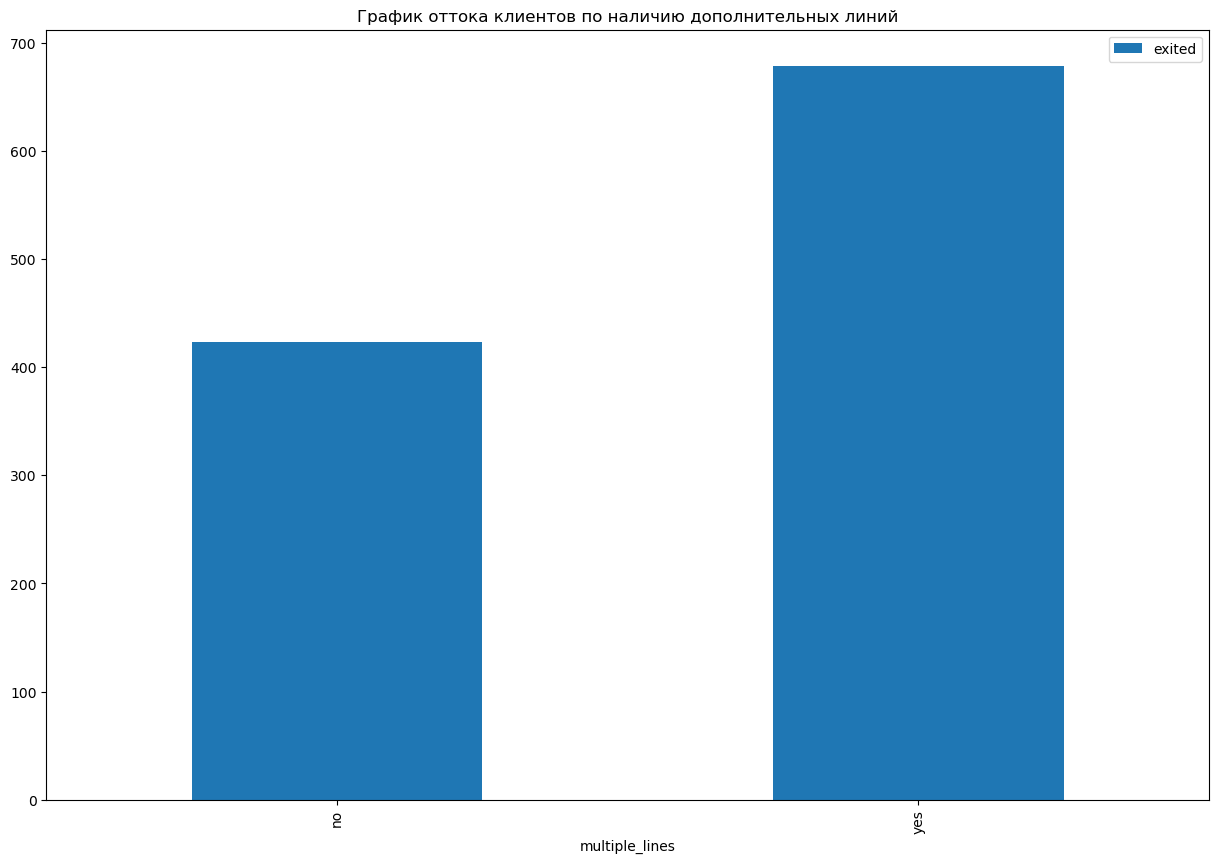

In [60]:
data.pivot_table(index='multiple_lines', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по наличию дополнительных линий')
pass

График похож на график по наличию партнеров, тут также, клиенты, которые пользуются дополнительные линиями почти в **2** раза чаще расторгают договор с компанией.

Добавим два новых столбца - `begin_date_month` и `end_data_month`, заполним эти столбцы данными о том, в каком месяце клиент заключил договор и в каком месяце клиент прекратил пользоваться услугами. С помощью этих столбцов сможем определить в какое время происходит максимальный прирост и отток клиентов.

In [61]:
data['begin_date_month'] = data['begin_date'].dt.month
data['end_date_month'] = data['end_date'].dt.month
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,...,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,added_services,begin_date_month,end_date_month
0,7590-vhveg,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,0,2020,...,no,no,female,0,yes,no,no,1,1,NaN
1,5575-gnvde,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,0,2017,...,no,no,male,0,no,no,no,1,4,NaN
2,3668-qpybk,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,0,2019,...,no,no,male,0,no,no,no,1,10,NaN
3,7795-cfocw,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,0,2016,...,no,no,male,0,no,no,no,1,5,NaN
4,9237-hqitu,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,0,2019,...,no,no,female,0,no,no,no,0,9,NaN


Столбцы успешно добавились. Добавим ещё один столбец `duration` и заполним его длительностью использования услуг клиента там, где не заполнено столбец с датой прекращения договора.

In [62]:
data['duration'] = round((data['end_date_year'] - data['begin_date_year']) + (
    (data['end_date_month'] - data['begin_date_month']) / 12), 1)
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,...,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,added_services,begin_date_month,end_date_month,duration
0,7590-vhveg,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,0,2020,...,no,female,0,yes,no,no,1,1,NaN,NaN
1,5575-gnvde,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,0,2017,...,no,male,0,no,no,no,1,4,NaN,NaN
2,3668-qpybk,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,0,2019,...,no,male,0,no,no,no,1,10,NaN,NaN
3,7795-cfocw,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,0,2016,...,no,male,0,no,no,no,1,5,NaN,NaN
4,9237-hqitu,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,0,2019,...,no,female,0,no,no,no,0,9,NaN,NaN


У нас остались пропуски в столбце `duration` - длительность договора, нам известно, что нам предоставлены данные до 1 февраля 2020 года, для заполнения пропусков используем тот же способ, что и ранее для расчета длительности договора, только вместо года окончания договора укажем **2020** год, а вместо месяца окончания договора **2** месяц:

In [63]:
data['duration'] = data['duration'].fillna(round((2020 - data['begin_date_year']) + (
    (2 - data['begin_date_month']) / 12), 1))
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,...,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,added_services,begin_date_month,end_date_month,duration
0,7590-vhveg,2020-01-01,NaT,month-to-month,yes,electronic check,29.85,31.04,0,2020,...,no,female,0,yes,no,no,1,1,NaN,0.1
1,5575-gnvde,2017-04-01,NaT,one year,no,mailed check,56.95,2071.84,0,2017,...,no,male,0,no,no,no,1,4,NaN,2.8
2,3668-qpybk,2019-10-01,NaT,month-to-month,yes,mailed check,53.85,226.17,0,2019,...,no,male,0,no,no,no,1,10,NaN,0.3
3,7795-cfocw,2016-05-01,NaT,one year,no,bank transfer (automatic),42.30,1960.60,0,2016,...,no,male,0,no,no,no,1,5,NaN,3.8
4,9237-hqitu,2019-09-01,NaT,month-to-month,yes,electronic check,70.70,353.50,0,2019,...,no,female,0,no,no,no,0,9,NaN,0.4


Новый столбец с длительностью договора успешно добавился. Постороим теперь график по месяца начала договора и прекращения договора, чтобы определить влияет ли время года факт ухода клиента:

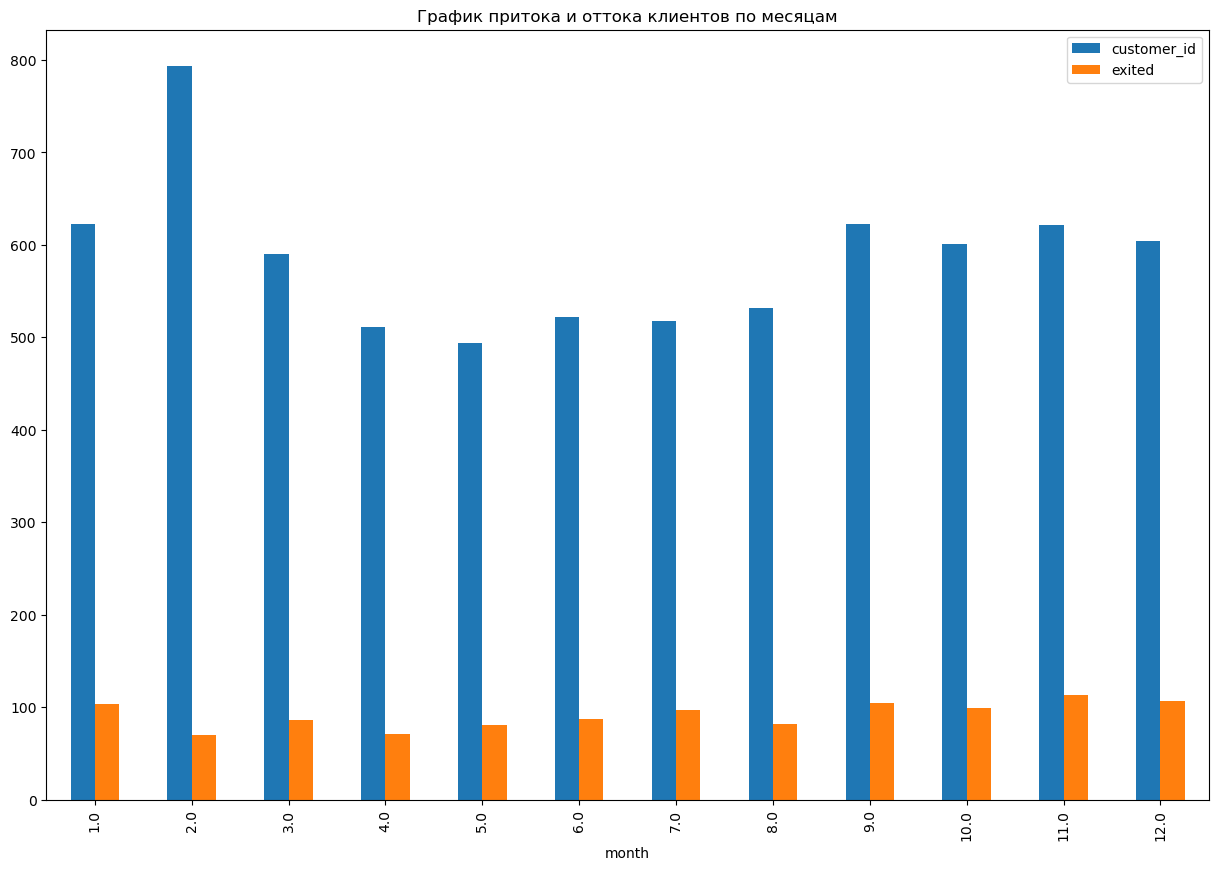

In [64]:
data.pivot_table(index='begin_date_month', values='customer_id', aggfunc='count').join(
    data.pivot_table(index='end_date_month', values='exited', aggfunc='sum')
).plot(kind='bar', figsize=(15, 10), title='График притока и оттока клиентов по месяцам', xlabel='month')
pass

Как видно на графике самый большой приток клиентов происходит в основном во **2** месяце, в этом же месяце самый низкий отток клиентов, затем приток клиентов идет на спад до **6** месяца, и затем он снова начинает постпенно расти. Самые высокие показатели по оттоку клиенту наблюдается в **1** месяце и с **9** по **12** месяца. Можно сделать вывод, что в осенее и зимнее время вероятность, что уйдет клиент больше, чем в остальные месяца. В весенее и летнее время наоборот - вероятность, что клиент уйдет меньше, чем в остальные месяца.

Построим теперь график оттока клиентов по месяцу заключения договора:

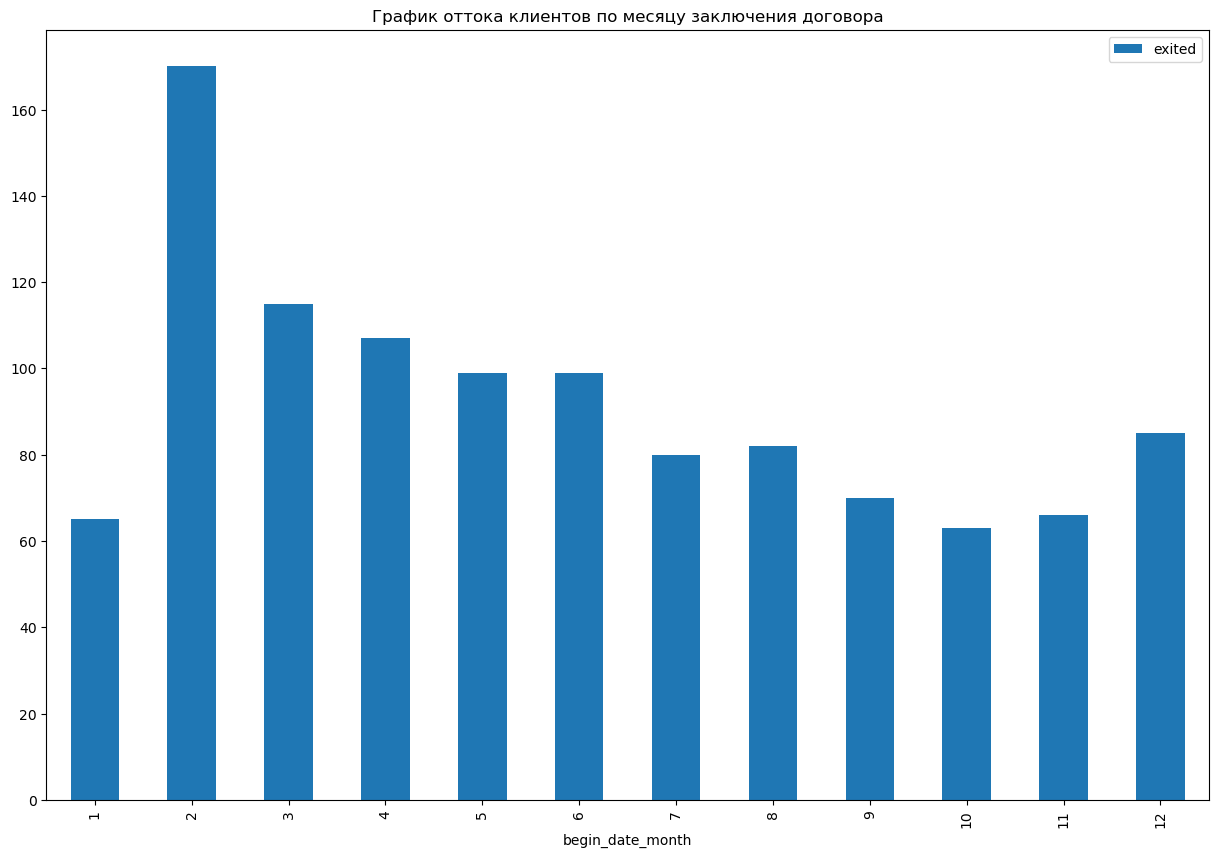

In [65]:
data.pivot_table(index='begin_date_month', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по месяцу заключения договора')
pass

Согласно графику больше расторгает договоры те клиенты, кто заключил договор в феврале месяце, скорее всего это связано с тем, что клиенты больше всего заключают договора в феврале, однако стоит отметить, что согласно предыдущему графику январь идет после февраля, по количеству клиентов, которые заключили договор, однако отток клиентов в январе один из самых низких. Аналогичная ситуация с клиентами, которые заключили договора в сентябре, октярбре и ноябре, приток клиентов практически такой как в январе, однако отток клиентов тоже один из самых низких.

Построим график по длительностью договоров, чтобы определить через какое время пользования услуг клиенты расторгают договор:

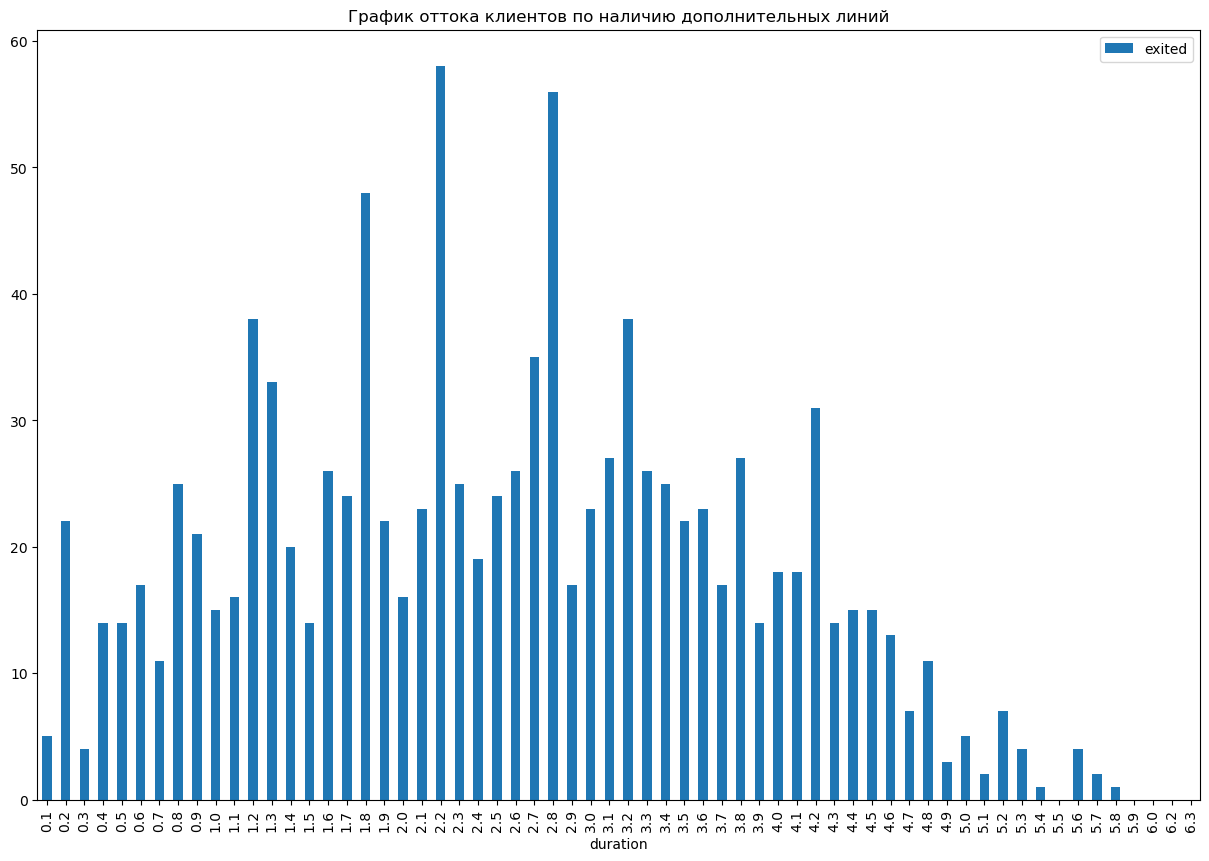

In [66]:
data.pivot_table(index='duration', values='exited', aggfunc='sum').plot(
    kind='bar', figsize=(15, 10), title='График оттока клиентов по наличию дополнительных линий')
pass

Как можно заметить на графике, после **4.5** лет пользования услугами компании, отток клиентов идет на спад, после **5** лет пользования услугами компании наблюдается самый низкий отток по клиентам по сравнению с клиентами, которые меньше пользовались услугами компании, можно также заметить, что клиенты, которые пользуются услугами компании меньше года чаще расторгают договор с компанией, чем клиенты, которые пользуются услугами компании больше **5** лет, это связано с тем, что скорее всего новых клиентов не устраивает качество работы компании и компания не может данных клиентов удержать. Самые высокие показатели по оттоку клиентов наблюдаются после **1.5** лет пользования услугами компании, на графике можно увидеть так называемые пики, в это время произошел самый большой отток клиентов. На основании вышеизложенного, можно сделать вывод, что вероятность ухода выше у тех клиентов, которые пользуются услугами компании меньше **4.5** лет.

Проведем корреляционный анализ, чтобы определить какие столбцы связаны между собой, корреляцию будет проводить с помощью коэффицента **Phik**, так как в датафрейме указаны разные типы данных, а данный коэффицент позволяет вычислять взаимосвязи между различными типами признаков (категориальными, непрерывными и их комбинациями):

In [67]:
pd.set_option('display.max_columns', None)
data_corr = data.phik_matrix()
data_corr = data_corr.drop('customer_id', axis=1)
data_corr = data_corr.drop('customer_id', axis=0)
data_corr

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'exited', 'begin_date_year', 'end_date_year', 'senior_citizen', 'added_services', 'begin_date_month', 'end_date_month', 'duration']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,exited,begin_date_year,end_date_year,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,added_services,begin_date_month,end_date_month,duration
begin_date,1.000000,0.000000,0.765275,0.078664,0.467586,0.421848,0.773731,0.461977,1.000000,0.544660,0.185601,0.414870,0.457995,0.468675,0.410714,0.369979,0.381092,0.018540,0.049516,0.485513,0.201169,0.440017,0.345513,1.000000,0.000000,0.978275
end_date,0.000000,1.000000,0.398284,0.065379,0.120097,0.000000,0.051673,NaN,0.502906,1.000000,0.000000,0.156608,0.218555,0.228528,0.168624,0.106982,0.050495,0.046046,0.054282,0.086772,0.076916,0.113805,0.104221,0.000000,1.000000,0.595405
type,0.765275,0.398284,1.000000,0.106151,0.277528,0.388557,0.470700,0.094622,0.606951,0.438966,0.503776,0.152239,0.099016,0.137817,0.180169,0.067123,0.070375,0.000000,0.085800,0.179294,0.146126,0.065750,0.050727,0.259082,0.151275,0.636096
paperless_billing,0.078664,0.065379,0.106151,1.000000,0.368945,0.467547,0.202168,0.082789,0.061956,0.000000,0.231145,0.000000,0.196937,0.161234,0.055354,0.344114,0.325351,0.000000,0.241715,0.010489,0.170650,0.253299,0.385069,0.045306,0.000000,0.008199
payment_method,0.467586,0.120097,0.277528,0.368945,1.000000,0.398849,0.334563,0.214300,0.329545,0.148827,0.323013,0.261704,0.282245,0.306678,0.270893,0.377241,0.378375,0.000000,0.291989,0.244661,0.222859,0.339987,0.450161,0.121368,0.000000,0.349294
monthly_charges,0.421848,0.000000,0.388557,0.467547,0.398849,1.000000,0.711015,0.225823,0.334907,0.122254,0.919005,0.550855,0.629276,0.667621,0.576163,0.835680,0.833111,0.005522,0.304546,0.204575,0.182283,0.676393,0.979694,0.151866,0.000000,0.387936
total_charges,0.773731,0.051673,0.470700,0.202168,0.334563,0.711015,1.000000,0.303758,0.673736,0.298220,0.489363,0.522660,0.623588,0.642431,0.550988,0.642937,0.644346,0.000000,0.136856,0.383135,0.085809,0.573224,0.681208,0.253422,0.000000,0.846614
exited,0.461977,NaN,0.094622,0.082789,0.214300,0.225823,0.303758,1.000000,0.336920,NaN,0.056279,0.132914,0.229736,0.218622,0.103933,0.200334,0.221756,0.008800,0.085708,0.227597,0.048710,0.261345,0.202891,0.112860,NaN,0.367120
begin_date_year,1.000000,0.502906,0.606951,0.061956,0.329545,0.334907,0.673736,0.336920,1.000000,0.586517,0.137245,0.299087,0.336736,0.334919,0.297403,0.268770,0.270693,0.024858,0.052759,0.347780,0.144525,0.317056,0.248359,0.330856,0.142051,0.866024
end_date_year,0.544660,1.000000,0.438966,0.000000,0.148827,0.122254,0.298220,NaN,0.586517,1.000000,0.010236,0.171564,0.213294,0.155097,0.171938,0.081259,0.142246,0.129993,0.000000,0.224036,0.061106,0.084156,0.051223,0.189947,0.343302,0.462692


In [68]:
pd.set_option('display.max_columns', 20)

В матрице корреляций заметно следующее - наличие подключенных дополнительных услуг коррелирует с месячным платежом и с тем сколько клиент всего потратил денег, какая-то услуга больше коррелируют больше, какая-то меньше, что логично, так как подключение дополнительных услуг увеличивает затраты клиента. Также с тем  сколько всего потратил денег клиент на услуги коррелируют длительность договор, это объясняется тем, что чем дольше клиент пользуются услугами, тем больше он на них тратит денег. 

У столбца `exited` - факт ухода клиента, нет сильной корреляции не с одним столбцом, в основном все корреляции слабые, есть даже те, что практически равны нулю, что говорит о том, что корреляция с этим столбцом практически отсутствует. Одним из таких столбцов является `gender`, ранее и на графике было заметно, что пол клиента не влияет на то, перестанет клиент пользоваться услугами компании или нет. 

Далее идет столбец `dependents` - наличие иждевенцев, у этого столбца корреляция лучше, чем у предыдущего, но она все равно достаточно мала, что говорит о том, что наличие иждевенцев не сильно влияет на то уйдет клиент или нет, хотя на графике было видно, что клиенты у которых нет иждевенцев чаще прекращали пользоваться услугами компании. 

Далее по корреляции практически рядом идут два столбца `senior_citizen` - клиент пенсионного возраста и `paperless_billing` - пользуется ли клиент электронные чеками, на графике мы видели, что клиенты пенсионного возраста достаточно реже прекращает пользоваться услугами компании, чем другие клиенты, однако судя по корреляции данный факт имеет не сильное влияние на уход клиента. 

Затем у нас по корреляции идет столбец `type` - тип оплаты по договору (каждый месяц, раз в год и раз в два года), корреляция здесь тоже достаточная слабая, что говорит о том, тип оплаты не оказывает сильного влияния на то уйдет клиент или нет. 

Далее по корреляции идут столбцы, в которых указывается факт подключения каких либо дополнительных услуг, здесь уже корреляции по лучше, но они все ещё слабые.

Корреляция с фактом ухода клиента больше, чем у стобцов в которых указывается наличие выделененной линии техподдержки и блокировки небезопасных сайтов, видимо есть какое-то недовольство у клиентов, которые подключали себе остальные услуги. Способ платежа, указанный в столбце `payment_method`, а также наличие партнера имеет практически такую же корреляцию как наличие у клиента услуга резервоного копирования, антивируса или стримингового телевидения.

Столбец `total_charges` - сколько всего заплатил клиент по договору, имеет все ещё слабую корреляция, однако больше, чем в столбцах, которые мы рассмотрели до этого, из чего можно сделать вывод, что небольшая связь между с тем сколько клиент потратил денег по договру и его уходом все-таки есть.

Самую высокую корреляцию, кроме столбца `begin_date` - дата заключения договора, со столбцом фактом уходом клиента имеет столбец `duration` - длительность договора, значение самой кореляции говорит о том, что она слабая, но как со столбцом `total_charges` можно утверждать, небольшая зависимость между ухода клиентом и длительность договора есть. Ранее с помощью графика по данному столбцу нам удалось определить, что клиенты у которых договор длится уже больше **4.5** лет гораздо реже уходят, чем остальные клиенты.

На основании проведенного исследовательского анализа, в качестве признаков для обучения моделей машинного обучения выберем следующие столбцы из датафрейма:

- `type` - тип оплаты по договору;
- `payment_method` - способ оплаты;
- `monthly_charges` - ежемесячные платеж;
- `total_charges` - сколько всего заплатил клиент по договору;
- `internet_service` - тип подключения интернета;
- `partner` - наличие у клиента партнера;
- `multiple_lines` - подключено несколько каналов интернета;
- `added_services` - факт подключения одной из дополнительный услуг;
- `begin_date_month` - месяц заключения договора;
- `duration` - длительность договора;
- `exited` - факт ухода клиента.

Признаки выбрали, можно теперь переходить к обучению моделей.

## Обучение моделей

Перед тем как приступить к обучению моделей, удалим из датафрейма столбцы, которые не будем использовать в обучении моделей.

In [69]:
data = data.drop(['customer_id', 'begin_date', 'end_date', 'paperless_billing', 'begin_date_year', 'end_date_year', 
                  'online_security', 'online_backup', 'device_protection', 'tech_support', 
                  'streaming_tv', 'streaming_movies', 'end_date_month', 
                  'gender', 'senior_citizen', 'dependents'], axis=1)
data.head()

,type,payment_method,monthly_charges,total_charges,exited,internet_service,partner,multiple_lines,added_services,begin_date_month,duration
0,month-to-month,electronic check,29.85,31.04,0,dsl,yes,no,1,1,0.1
1,one year,mailed check,56.95,2071.84,0,dsl,no,no,1,4,2.8
2,month-to-month,mailed check,53.85,226.17,0,dsl,no,no,1,10,0.3
3,one year,bank transfer (automatic),42.30,1960.60,0,dsl,no,no,1,5,3.8
4,month-to-month,electronic check,70.70,353.50,0,fiber optic,no,no,0,9,0.4


Столбцы успешно удалились, посмотрим теперь как распределены значения в столбце `exited` - факт ухода клиента, который мы собираемся предсказывать:

In [70]:
data.groupby('exited').agg('count')['type']

exited
0    5931
1    1101
Name: type, dtype: int64

В данных преобладают клиенты, который ещё не ушли, всего **15%** клиентов у которых проставлен факт того, что они перестали пользоваться услугами компании.

Перейдем к разделению данных на выборки для обучения моделей машинного обучения. Данные будем разбивать на две выборки — обучащая **75%**, и тестовая **25%**, для этого воспользуемся методом `train_test_split` из библиотеки `sklearn`.

In [71]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE, shuffle=True)
print(data_train.shape)
print(data_test.shape)

(5274, 11)
(1758, 11)


По размерности видно, что выборки разделились корректно, теперь выбирем из данных признаки и что необходимо предсказать. По заданию нам необходимо **построить модель, которая предскажет какой клиент собирается уходить**. Факт ухода клиента мы ранее вынесли в столбец `exited` (1 — клиент ушел, 0 — клиент остался), это наш целевой признак, который нам необходимо будет предсказать, а все остальные столбцы вынесем в признаки по которым будем предсказывать целевой признак.

In [72]:
data_train_features = data_train.drop(['exited'], axis=1)
data_train_target = data_train['exited']

data_test_features = data_test.drop(['exited'], axis=1)
data_test_target = data_test['exited']

print(data_train_features.shape)
print(data_train_target.shape)
print(data_test_features.shape)
print(data_test_target.shape)

(5274, 10)
(5274,)
(1758, 10)
(1758,)


Выборки по признакам разделились корректно. В данных есть категориальные признаки, чтобы модели могли их использовать для обучения, необходимо их закодировать, кодировать признаки будем через **OneHotEncoding**, то есть **OHE**.

In [73]:
column_categorial = ['type', 'payment_method', 'internet_service', 'partner', 'multiple_lines']

data_train_features_ohe = data_train_features.copy()
data_test_features_ohe = data_test_features.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(data_train_features_ohe[column_categorial])

data_train_features_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(data_train_features_ohe[column_categorial])
data_train_features_ohe = data_train_features_ohe.drop(column_categorial, axis=1)
data_train_features_ohe.head()

,monthly_charges,total_charges,added_services,begin_date_month,duration,type_one year,type_two year,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,internet_service_fiber optic,internet_service_no,partner_yes,multiple_lines_yes
5740,99.50,5870.50,1,3,4.9,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6529,79.85,239.55,1,11,0.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1713,19.90,355.21,0,9,1.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4180,20.25,729.00,0,2,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1726,69.60,147.55,0,12,0.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


В обучающей выборке категориальные признаки успешно закодированы, сделаем тоже самое на тестовой выборке:

In [74]:
data_test_features_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(data_test_features_ohe[column_categorial])
data_test_features_ohe = data_test_features_ohe.drop(column_categorial, axis=1)
data_test_features_ohe.head()

,monthly_charges,total_charges,added_services,begin_date_month,duration,type_one year,type_two year,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,internet_service_fiber optic,internet_service_no,partner_yes,multiple_lines_yes
4550,85.25,2557.50,1,8,2.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1386,85.80,2488.20,1,9,2.4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2565,94.05,3003.02,1,7,2.6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4831,73.75,663.75,0,5,0.8,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1913,54.95,1371.55,1,2,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Категориальные признаки в тестовой выборке также успешно закодировались. В данных осталось числовые признаки - `monthly_charges` - месячный платеж, `total_charges` - сколько клиент потратил на услуги и `duration` - длительность договора, данные признаки имеют различный разброс значений, очевидно, что значения затрат клиента на услуги, где-то значения превышаеют тысячи, будут сильно отличаться от длительность договора, где значения не доходят и до десятка. Чтобы модели при обучении не давали предпочитания тем признакам, которые имеют большие значения, сделаем масштабирования данных признаков. Масштабирование признаков будем делать через стандартизацию данных, для этого воспользуемся структурой *StandardScaler* из библиотеки `sklearn`.

In [75]:
scaler = StandardScaler()
num_features = data_train_features.select_dtypes(exclude='object').columns.to_list()
num_features.remove('added_services') #факт подключения одной из услуг это категориальный бинарный признак
num_features.remove('begin_date_month') #месяц подключения услуги это категориальный признак

data_train_features_ohe[num_features] = scaler.fit_transform(data_train_features_ohe[num_features])
data_train_features_ohe.head()

,monthly_charges,total_charges,added_services,begin_date_month,duration,type_one year,type_two year,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,internet_service_fiber optic,internet_service_no,partner_yes,multiple_lines_yes
5740,1.147058,1.756816,1,3,1.290165,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6529,0.494790,-0.891018,1,11,-1.209491,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1713,-1.495209,-0.836632,0,9,-0.571281,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4180,-1.483591,-0.660865,0,2,0.279666,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1726,0.154548,-0.934279,0,12,-1.209491,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Данные в обучающей выборке успешно отмасштабировались, сделаем тоже самое на тестовой выборке:

In [76]:
data_test_features_ohe[num_features] = scaler.transform(data_test_features_ohe[num_features])
data_test_features_ohe.head()

,monthly_charges,total_charges,added_services,begin_date_month,duration,type_one year,type_two year,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,internet_service_fiber optic,internet_service_no,partner_yes,multiple_lines_yes
4550,0.674039,0.198948,1,8,0.013745,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1386,0.692296,0.166361,1,9,-0.039439,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2565,0.966149,0.408444,1,7,0.066929,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4831,0.292305,-0.691547,0,5,-0.890386,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1913,-0.331748,-0.358719,1,2,-0.252176,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


На тестовой выборке масштабирования числовых признаков тоже выполнилось успешно. Так как мы планируем использовать модели **CatBoost** и в данную модель для обучения планируется передевать выборки без кодирования через **OHE** выполним масштабирования признаков на обучающей и тестовой выборке до применения кодирования категориальных признаков через **OHE**:

In [77]:
#стандартизация данных на изначальном выборке для модели CatBoost
data_train_features[num_features] = scaler.transform(data_train_features[num_features])
data_train_features.head()

,type,payment_method,monthly_charges,total_charges,internet_service,partner,multiple_lines,added_services,begin_date_month,duration
5740,one year,electronic check,1.147058,1.756816,fiber optic,no,yes,1,3,1.290165
6529,month-to-month,electronic check,0.494790,-0.891018,fiber optic,no,no,1,11,-1.209491
1713,one year,bank transfer (automatic),-1.495209,-0.836632,no,no,no,0,9,-0.571281
4180,two year,bank transfer (automatic),-1.483591,-0.660865,no,yes,no,0,2,0.279666
1726,month-to-month,electronic check,0.154548,-0.934279,fiber optic,no,no,0,12,-1.209491


In [78]:
data_test_features[num_features] = scaler.transform(data_test_features[num_features])
data_test_features.head()

,type,payment_method,monthly_charges,total_charges,internet_service,partner,multiple_lines,added_services,begin_date_month,duration
4550,month-to-month,electronic check,0.674039,0.198948,fiber optic,no,yes,1,8,0.013745
1386,month-to-month,electronic check,0.692296,0.166361,fiber optic,yes,yes,1,9,-0.039439
2565,month-to-month,credit card (automatic),0.966149,0.408444,fiber optic,yes,yes,1,7,0.066929
4831,month-to-month,mailed check,0.292305,-0.691547,fiber optic,no,yes,0,5,-0.890386
1913,month-to-month,electronic check,-0.331748,-0.358719,dsl,no,no,1,2,-0.252176


На изначальных выборках числовые признаки успешно отмасштабировались.

Возьмем для решения нашей задачи несколько моделей машинного обучения — **Дерево решений**, **Случайный лес**, **Логистическая регрессия** и **CatBoost** переберем в них гиперпараметры с помощью кросс-валидации, чтобы найти лучшую модель для решения нашей задачи. Для оценок моделей будем использовать метрики *ROC-AUC* и *accuracy* для интерпретируемости. 

Начнем с того, что инициализируем датафрейм в который будемзаписываем полученные значения по метрикам, а также напишем небольшую функцию через которую будем заполнять данный датафрейм.

In [79]:
data_metrics = pd.DataFrame({'model': [], 'roc_auc': []})

In [80]:
def fill_metrics_score(metrics, index, model_name, val_roc_auc_score):
    '''
    Функция записывает полученные метрики по моделям в таблицу
    '''
    metrics.loc[index, 'model'] = model_name
    metrics.loc[index, 'roc_auc'] = val_roc_auc_score
    return metrics

In [81]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_tree_roc_auc = GridSearchCV(model_tree, param_grid={'max_depth': [1, 30]}, scoring='roc_auc', cv=5, n_jobs=-1)
grid_tree_roc_auc.fit(data_train_features_ohe, data_train_target)
print('Best params roc_auc', grid_tree_roc_auc.best_params_)

data_metrics = fill_metrics_score(data_metrics, len(data_metrics), 'DecisionTreeClassifier', 
                                  round(grid_tree_roc_auc.best_score_, 4))
data_metrics

Best params roc_auc {'max_depth': 30}


,model,roc_auc
0,DecisionTreeClassifier,0.6688


У модели **Дерево решений** наилучшее значение по метрике *ROC-AUC* достигается при глубине дерева равное **30** и равно - **0.6688**. Сделаем теперь перебор гиперпараметров через кросс-валидацию для модели **Случайный лес**:

In [82]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
params = {
    'max_depth': range(5, 31, 5),
    'n_estimators': range(10, 51, 10)
}

grid_forest_roc_auc = GridSearchCV(model_forest, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
grid_forest_roc_auc.fit(data_train_features_ohe, data_train_target)
print('Best params roc_auc', grid_forest_roc_auc.best_params_)

data_metrics = fill_metrics_score(data_metrics, len(data_metrics), 'RandomForestClassifier', 
                                  round(grid_forest_roc_auc.best_score_, 4))
data_metrics

Best params roc_auc {'max_depth': 15, 'n_estimators': 50}


,model,roc_auc
0,DecisionTreeClassifier,0.6688
1,RandomForestClassifier,0.8524


У модели **Случайный лес** наилучшее значение по метрике *ROC-AUC* достигается при глубине дерева равное **15** и количества деревьев равное **50** и равно - **0.8524**. Сделаем перебор гиперпараметров через кросс-валидацию для модели **Логистическая регрессия**:

In [83]:
model_log_rec = LogisticRegression(random_state=RANDOM_STATE)
params = {
    'max_iter': [100, 1000, 10000],
    'solver': ['lbfgs', 'liblinear']
}

grid_log_rec_roc_auc = GridSearchCV(model_log_rec, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
grid_log_rec_roc_auc.fit(data_train_features_ohe, data_train_target)
print('Best params roc_auc', grid_log_rec_roc_auc.best_params_)

data_metrics = fill_metrics_score(data_metrics, len(data_metrics), 'LogisticRegression', 
                                  round(grid_log_rec_roc_auc.best_score_, 4))
data_metrics

Best params roc_auc {'max_iter': 1000, 'solver': 'lbfgs'}


,model,roc_auc
0,DecisionTreeClassifier,0.6688
1,RandomForestClassifier,0.8524
2,LogisticRegression,0.7617


У модели **Логистическая регрессия** наилучшее значение по метрике *ROC-AUC* достигается при количестве итераций равное **1000** и когда параметр `solver` равен **lbfgs** и равно - **0.7617**.

Проверим ещё модель **CatBoost**, здесь будем использовать выборку без преобразованных категориальных признаков, так как **CatBoost** сам может преобразовывать данные признаки. Также здесь для перебора гиперпараметров через кросс-валидацию будет использоваться готовый метод **grid_search**, а не как для других моделей **GridSearchCV**:

In [84]:
params = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [100]
}

model_catboost_auc = catboost.CatBoostClassifier(random_state=RANDOM_STATE, verbose=25, cat_features=column_categorial, 
                                                 eval_metric='AUC:hints=skip_train~false')
grid_catboost_auc = model_catboost_auc.grid_search(params, X=data_train_features, y=data_train_target, shuffle=True)

print('Best params roc_auc', grid_catboost_auc['params'])

data_metrics = fill_metrics_score(data_metrics, len(data_metrics), 'CatBoost', 
                                  round(
                                      sum(grid_catboost_auc['cv_results']['test-AUC-mean']) / len(
                                          grid_catboost_auc['cv_results']['test-AUC-mean']), 4))
data_metrics

0:	learn: 0.7432679	test: 0.7519022	best: 0.7519022 (0)	total: 164ms	remaining: 16.2s
25:	learn: 0.8005997	test: 0.8053354	best: 0.8055286 (24)	total: 453ms	remaining: 1.29s
50:	learn: 0.8273757	test: 0.8363282	best: 0.8363282 (50)	total: 806ms	remaining: 774ms
75:	learn: 0.8388756	test: 0.8496097	best: 0.8496097 (75)	total: 1.17s	remaining: 371ms
99:	learn: 0.8433915	test: 0.8524972	best: 0.8524972 (99)	total: 1.44s	remaining: 0us

bestTest = 0.852497158
bestIteration = 99

0:	loss: 0.8524972	best: 0.8524972 (0)	total: 1.5s	remaining: 43.6s
0:	learn: 0.7432679	test: 0.7519022	best: 0.7519022 (0)	total: 10.6ms	remaining: 1.05s
25:	learn: 0.8374391	test: 0.8455779	best: 0.8457749 (24)	total: 307ms	remaining: 873ms
50:	learn: 0.8471661	test: 0.8495415	best: 0.8495415 (50)	total: 592ms	remaining: 568ms
75:	learn: 0.8716555	test: 0.8708943	best: 0.8708943 (75)	total: 925ms	remaining: 292ms
99:	learn: 0.9151896	test: 0.9044449	best: 0.9044449 (99)	total: 1.25s	remaining: 0us

bestTest = 0.9

,model,roc_auc
0,DecisionTreeClassifier,0.6688
1,RandomForestClassifier,0.8524
2,LogisticRegression,0.7617
3,CatBoost,0.8827


Наилучший показатель у модели **CatBoost** по метрике *ROC-AUC* достигается при количестве итераций обучения равное **100**, глубине дерева равное **10**, скорости обучения равное **0.1** и когда коэффициент при члене регуляризации L2 функции потерь равен **3** и равно - **0.8827**.

Выше в таблице отображается значение по метрикам *ROC-AUC* по всем моделям, которые мы обучили, по метрике по метрике *ROC-AUC* у всех моделей значения разные, наилучшее значение по данной метрике у модели **Случайный лес** и **CatBoost**, обе эти модели прошли порог в **0.85**, однако у модели **CatBoost** значение по метрике *ROC-AUC* выше, чем у модели **Случайный лес**. У модели **Случайный лес** значение по метрике *ROC-AUC* считай равно пороговому значению, у модели **CatBoost** значение по данной метрике чуть выше порогового. На основании вышеизложенного на тестовой выборке будем использовтаь модель **CatBoost**. Для того, чтобы оценить значение по метрике *ROC-AUC* на тестовой выборке, постороим ROC-кривую.

0:	learn: 0.7954812	total: 31.3ms	remaining: 3.09s
25:	learn: 0.9105846	total: 776ms	remaining: 2.21s
50:	learn: 0.9288025	total: 1.38s	remaining: 1.32s
75:	learn: 0.9440463	total: 2.07s	remaining: 654ms
99:	learn: 0.9572083	total: 2.77s	remaining: 0us
Accuracy на тестовой выборке: 0.891353811149033


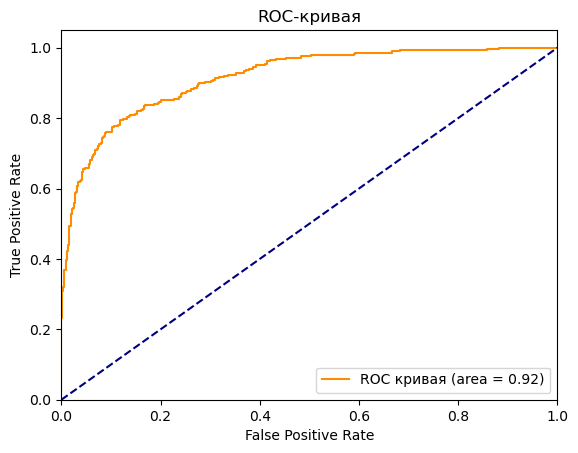

In [85]:
best_model_catboost = catboost.CatBoostClassifier(random_state=RANDOM_STATE, verbose=25, cat_features=column_categorial, 
                                                  iterations=100, eval_metric='AUC:hints=skip_train~false', depth=10, 
                                                  learning_rate=0.1, l2_leaf_reg=3)
best_model_catboost.fit(data_train_features, data_train_target)
best_model_catboost_predict = best_model_catboost.predict_proba(data_test_features)
best_model_catboost_proba = best_model_catboost_predict[:, 1]
print('Accuracy на тестовой выборке:', accuracy_score(data_test_target, best_model_catboost.predict(data_test_features)))

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(data_test_target, best_model_catboost_proba)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Модель **CatBoost** показывает хорошие результаты на тестовой выборке, значение по метрике *accuracy* равно **0.89**, по метрике *ROC-AUC* согласно ROC-кривой значение **0.92**, значение выше **0.85**, которое дается по заданию, что говорит о том, что мы сделали правильный выбор в пользу этой модели. Проверим делает ли наша модель адекватные предсказания с помощью случайной модели. Для проверки модели на вменяемость воспользуемся моделью `DummyClassifier` из библиотеки `sklearn`. Чтобы проверить с помощью данной модели обученную модель **CatBoost** укажем для гиперпараметра `strategy` — *стратегия, используемая для создания прогнозов* значение `uniform`, тогда модель `DummyClassifier` сгенерирует прогнозы равномерно случайным образом из списка уникальных классов, то есть в модели равновероятно будут распределены факт ухода клиента:

In [86]:
model_dummy = DummyClassifier(strategy='uniform')
model_dummy.fit(data_train_features_ohe, data_train_target)
predictions_dummy = model_dummy.predict(data_test_features_ohe)
print('Accuracy на тестовой выборке', accuracy_score(data_test_target, predictions_dummy))
print('ROC-AUC на тестовой выборке', roc_auc_score(data_test_target, predictions_dummy))

Accuracy на тестовой выборке 0.4852104664391354
ROC-AUC на тестовой выборке 0.482780612244898


У модели с равномерным случайным распределением факта ухода клиента, значение по метрике *ROC-AUC* равно **0.48**, что говорит о том, что наша модель **CatBoost** делает адекватные предсказания, так как у неё значение по метрике *ROC-AUC* равно **0.92**.

Посмотрим теперь на важность признаков у модели **CatBoost**:

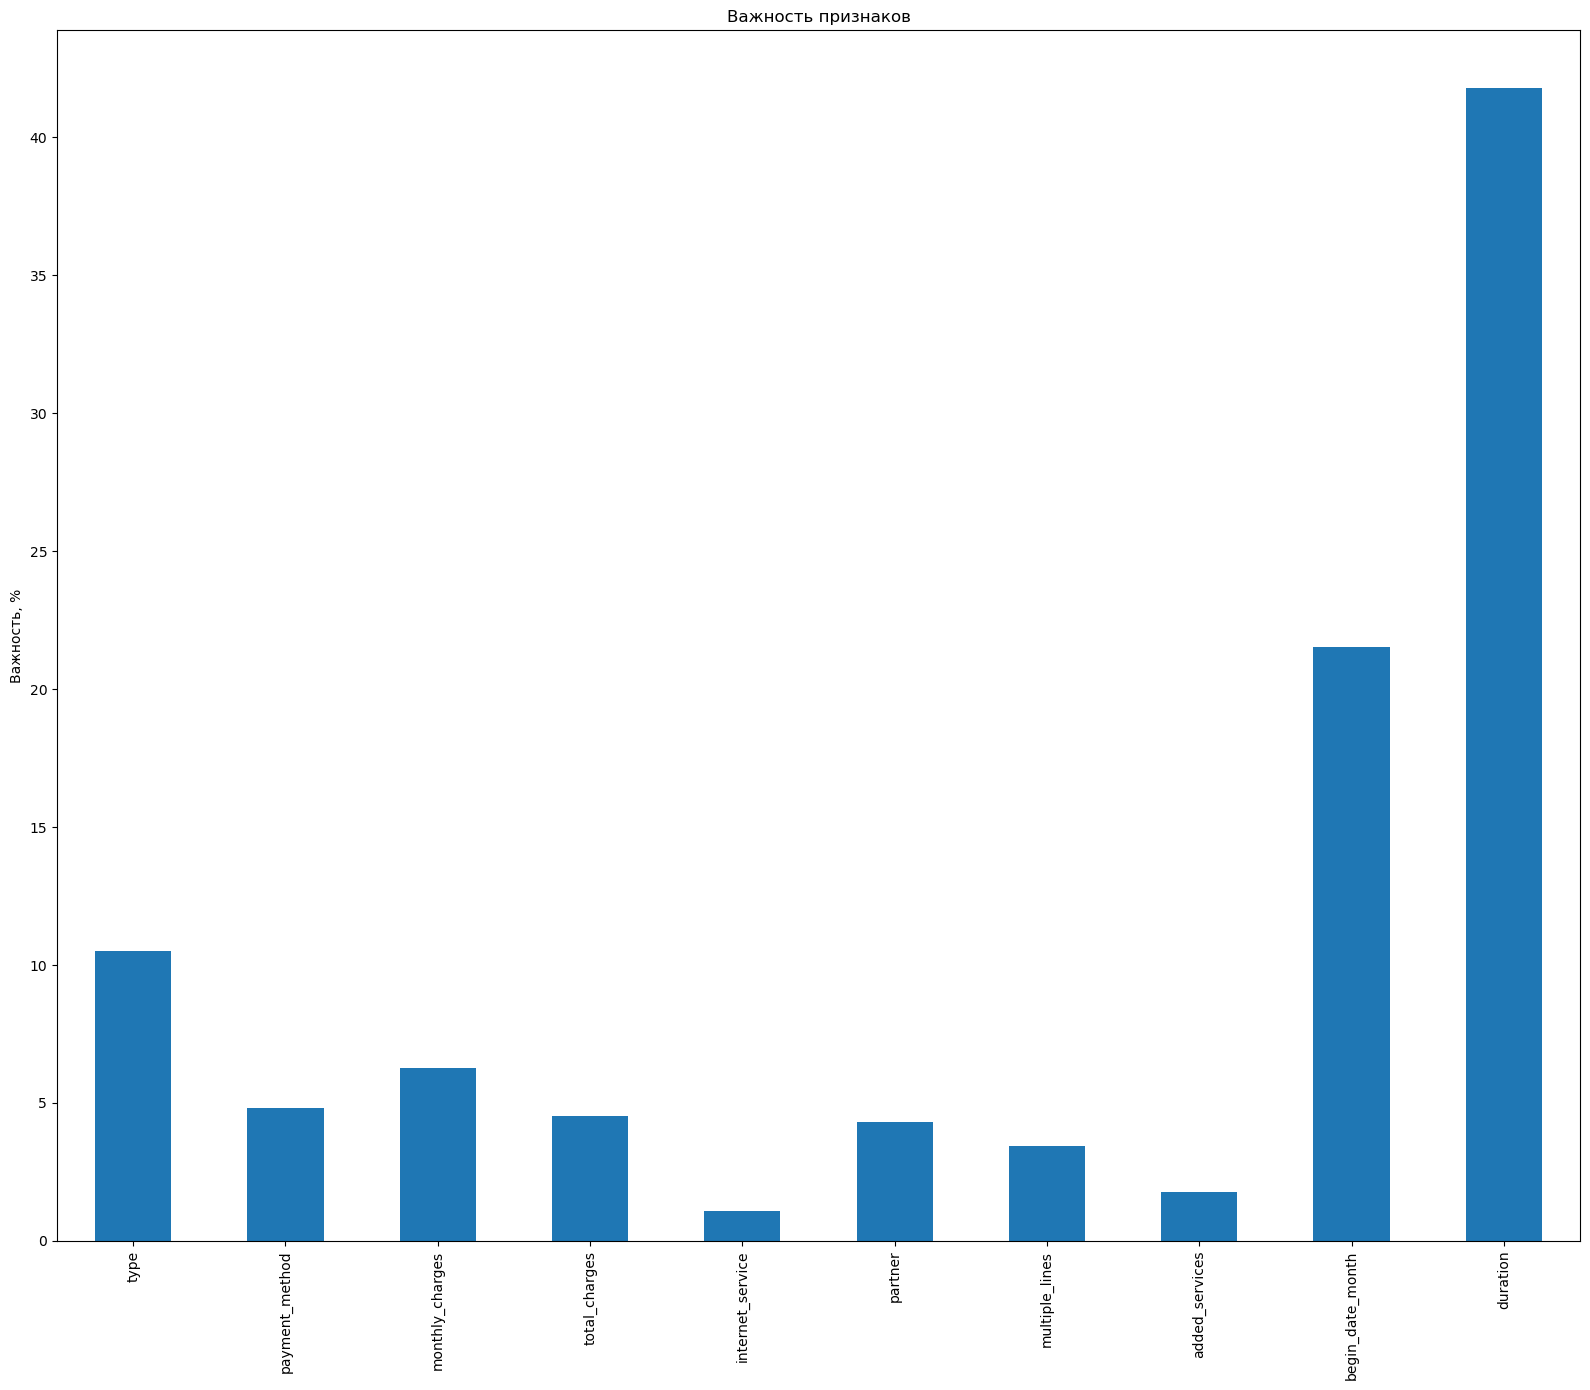

In [87]:
cat_imp = pd.Series(best_model_catboost.get_feature_importance(),
                    data_train_features.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Модель **CatBoost** считает самыми важными признаками `duration` - длительность договора и `begin_date_month` - месяц заключения договора, важность составляет где-то **40%** и **25%** соотвественно, затем по важности идет признак `type` - тип оплаты по договору, но здесь уже важности падает где-то до **10%**. Самые низкая важность у признаков `internet_service` - тип подключения интернета и `added_services` - факт подключения дополнительных услуг.

Построим матрицу ошибок, чтобы детальнее рассмотреть как модель **CatBoost** классифицирует классы на тестовой выборке:

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция строит матрицу ошибок
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

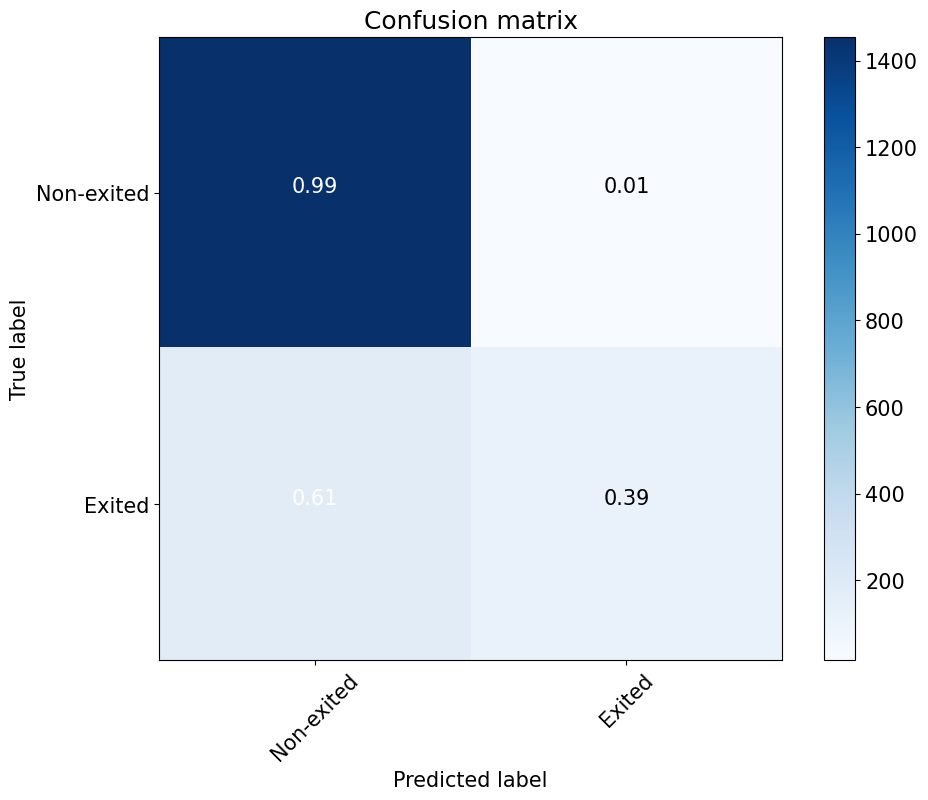

In [89]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(data_test_target, best_model_catboost.predict(data_test_features))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-exited', 'Exited'],
                      title='Confusion matrix')
plt.show()

Согласно матрице ошибок, наша модель хорошо справляется с определением тех клиентов, которые не собираются уходить, всего **1%** клиентов модель ошибочно отнесла к тем, кто собирается уходить. С определением клиентов, которые собираются уходить, модель справляется хуже, **39%** клиентов модель верно относит к тем, кто собирается уходить.

### Общий вывод

В рамках проекта нам нужно было построить модель машинного обучения, которая предсказывает какой-то клиент собирается прекратить пользоваться услугами телекоммуникационной компании, по сути факт ухода клиента. Нам были предоставлены исторически по использовани услуг у клиентов, был проведен исследовательский и корреляционный анализ с помощью которого были определены признаки для обучения моделей. Для проверки качества обучения моделей необходимо было использовать метрику *ROC-AUC*, значение метрики не должно было быть меньше **0.85**. 

Было обучено несколько моделей машинного обучения по предоставленным данным и получены следующие результаты:
- `Дерево решений` значение по метрике *ROC-AUC* - **0.6688**;
- `Случайный лес` значение по метрике *ROC-AUC* - **0.8524**;
- `Логистическая регрессия` значение по метрике *ROC-AUC* - **0.7617**;
- `CatBoost` значение по метрике *ROC-AUC* - **0.8827**.

На основании проведенного обучения моделей на обучающей выборке с помощью кросс-валидации, была выбрана модель `CatBoost` с гиперпараметрами `iterations` - количество итераций обучения равно **100**, `depth` - глубина дерева равна **10**, `learning_rate` - скорость обучения равно **0.1** и `l2_leaf_reg` - коэффициент при члене регуляризации L2 функции потерь равен **3**. На тестовой выборке данная модель показала значение по метрике *ROC-AUC* равно **0.92**, что соответствуют условию в начале задания, также модель была успешно проверена на адекватность. 

На основании вышеизложенного, для предсказания факт ухода клиента необходимо использовать модель **CatBoost**, так как данная модель продемонстировала необходимый показатель по метркие *ROC-AUC*, а также была успешно проверена на адекватность предсказаний.